In [1]:
%load_ext autoreload
%autoreload 2

In [132]:
from dataclasses import dataclass
import logging
from pathlib import Path
import yaml

from omegaconf import OmegaConf, DictConfig
import pandas as pd
from matplotlib import transforms
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.analysis.trf import coefs_to_df
from src.encoding.ecog.timit import OutFile
from src.encoding.ecog import timit as timit_encoding, get_electrode_df, \
     AlignedECoGDataset, ContrastiveModelSnapshot, epoch_by_state_space
from src.viz.epoching import plot_epoch_raster

In [133]:
sns.set_theme(style="whitegrid", context="talk", font_scale=2)

In [134]:
L = logging.getLogger(__name__)

In [278]:
dataset = "timit-no_repeats"
study_models = {
    "Random": "random8",
    "Phoneme": "phoneme",
    "Biphone": "biphone_recon",
    # "Biphone predictive": "biphone_pred",
    "Word": "word_broad-aniso2-w2v2_8",
}
interpretable_feature_names = {
    "phnfeatConsOnset": "Consonant features",
    "onset": "Trial onset",
    "maxDtL": "peakRate",
    "F0": "Pitch",
    "formantMedOnset": "Formant features",
}
ttest_results_path = f"outputs/encoder_comparison_across_subjects/{dataset}/ttest.csv"
scores_path = f"outputs/encoder_comparison_across_subjects/{dataset}/scores.csv"

plot_subjects = ["EC212", "EC260"]

encoder_dirs = list(Path("outputs/encoders").glob(f"{dataset}/*/*"))
unique_variance_paths = list(Path(f"outputs/encoder_unique_variance/{dataset}/baseline").glob("*/unique_variance.csv"))

pval_threshold = 1e-3

In [279]:
study_model_codes = list(study_models.values())

In [280]:
scores_df = pd.read_csv(scores_path, index_col=["dataset", "subject", "model2", "model1"]).loc[dataset]
if study_model_codes is None:
    study_model_codes = sorted(scores_df.index.get_level_values("model2").unique())
    study_models = {code: code for code in study_model_codes}
else:
    scores_df = scores_df.loc[scores_df.index.get_level_values("model2").isin(study_model_codes)]
scores_df

study_model_code_to_name = {code: name for name, code in study_models.items()}

In [281]:
ttest_df = pd.read_csv(ttest_results_path, index_col=["dataset", "subject", "model2", "model1", "output_dim"]) \
    .loc[dataset].loc[(slice(None), study_model_codes), :]
ttest_df["log_pval"] = np.log10(ttest_df["pval"])
ttest_df

Unnamed: 4 permutation  \
subject model2                   model1   output_dim                           
EC152   random8                  baseline 165                  0       shift   
                                          116                  1       shift   
                                          129                  2       shift   
                                          133                  3       shift   
                                          101                  4       shift   
...                                                          ...         ...   
EC260   word_broad-aniso2-w2v2_8 baseline 169                107       shift   
                                          191                108       shift   
                                          94                 109       shift   
                                          114                110       shift   
                                          219                111       units   

                                                           tval          pval  \
subject model2                   model1   output_dim                            
EC152   random8                  baseline 165         64.420931  3.478131e-07   
                                          116         20.962180  3.060871e-05   
                                          129         20.348246  3.444157e-05   
                                          133         20.327161  3.458355e-05   
                                          101         19.955432  3.721096e-05   
...                                                         ...           ...   
EC260   word_broad-aniso2-w2v2_8 baseline 169          1.025800  3.629666e-01   
                                          191          0.871193  4.328148e-01   
                                          94          -0.734340  5.034666e-01   
                                          114         -0.056520  9.576384e-01   
                                          219         -0.001985  9.985112e-01   

                                                      log_pval  
subject model2                   model1   output_dim            
EC152   random8                  baseline 165        -6.458654  
                                          116        -4.514155  
                                          129        -4.462917  
                                          133        -4.461130  
                                          101        -4.429329  
...                                                        ...  
EC260   word_broad-aniso2-w2v2_8 baseline 169        -0.440133  
                                          191        -0.363698  
                                          94         -0.298029  
                                          114        -0.018798  
                                          219        -0.000647  

[4054 rows x 5 columns]

In [282]:
ttest_filtered_df = ttest_df.dropna().sort_values("pval", ascending=False) \
    .groupby(["subject", "model2", "output_dim"]).first()
ttest_filtered_df = ttest_filtered_df.loc[ttest_filtered_df["pval"] < pval_threshold]
ttest_filtered_df["model_name"] = ttest_filtered_df.index.get_level_values("model2").map(study_model_code_to_name)
ttest_filtered_df

Unnamed: 4 permutation  \
subject model2                   output_dim                           
EC152   biphone_recon            37                  18       shift   
                                 83                  11       shift   
                                 89                  16       shift   
                                 99                  13       shift   
                                 101                  8       shift   
...                                                 ...         ...   
EC260   word_broad-aniso2-w2v2_8 206                  1       units   
                                 220                  8       units   
                                 221                 18       shift   
                                 237                 11       shift   
                                 247                 27       units   

                                                   tval          pval  \
subject model2                   output_dim                             
EC152   biphone_recon            37            9.230326  7.656709e-04   
                                 83           14.322976  1.380496e-04   
                                 89            9.627193  6.509417e-04   
                                 99           13.436933  1.774527e-04   
                                 101          17.347487  6.481041e-05   
...                                                 ...           ...   
EC260   word_broad-aniso2-w2v2_8 206         144.044845  1.393224e-08   
                                 220          33.462128  4.757247e-06   
                                 221          19.455927  4.114653e-05   
                                 237          26.704379  1.168886e-05   
                                 247          10.995933  3.887305e-04   

                                             log_pval model_name  
subject model2                   output_dim                       
EC152   biphone_recon            37         -3.115958    Biphone  
                                 83         -3.859965    Biphone  
                                 89         -3.186458    Biphone  
                                 99         -3.750917    Biphone  
                                 101        -4.188355    Biphone  
...                                               ...        ...  
EC260   word_broad-aniso2-w2v2_8 206        -7.855979       Word  
                                 220        -5.322644       Word  
                                 221        -4.385667       Word  
                                 237        -4.932228       Word  
                                 247        -3.410351       Word  

[443 rows x 6 columns]

In [283]:
unique_variance_df = pd.concat([pd.read_csv(unique_variance_path, index_col=["dropped_feature", "fold", "output_dim"])
                                for unique_variance_path in unique_variance_paths],
                               names=["subject"], keys=[unique_variance_path.parent.name for unique_variance_path in unique_variance_paths]) \
    .reorder_levels(["dropped_feature", "subject", "fold", "output_dim"])
# ^ this is actually not unique variance, but the inputs to the calculation. let's do it:
unique_variance = unique_variance_df.loc[np.nan].unique_variance_score - unique_variance_df[~unique_variance_df.index.get_level_values("dropped_feature").isna()].unique_variance_score
unique_variance

subject  fold  output_dim  dropped_feature 
EC152    0     0           onset              -3.909205e-07
                           phnfeatConsOnset   -9.103857e-05
                           maxDtL              1.205160e-05
                           formantMedOnset    -4.784719e-04
                           F0                  1.452032e-03
                                                   ...     
EC260    2     255         onset               9.400353e-04
                           phnfeatConsOnset    1.374724e-03
                           maxDtL              9.055147e-05
                           formantMedOnset     2.891745e-04
                           F0                  1.848799e-02
Name: unique_variance_score, Length: 24960, dtype: float64

In [284]:
baseline_scores = pd.concat([pd.read_csv(encoder_dir / "scores.csv", index_col=["fold", "output_dim"])
                             for encoder_dir in encoder_dirs if "baseline" == encoder_dir.parent.name],
                            names=["subject"], keys=[encoder_dir.name for encoder_dir in encoder_dirs if "baseline" == encoder_dir.parent.name])
baseline_scores

score    output_name
subject fold output_dim                         
EC195   0    0          -0.002837     (0, 'GP1')
        1    0          -0.001149     (0, 'GP1')
        2    0          -0.003194     (0, 'GP1')
        0    1          -0.000995     (1, 'GP2')
        1    1          -0.003379     (1, 'GP2')
...                           ...            ...
EC152   1    254        -0.005269  (254, 'G255')
        2    254         0.001982  (254, 'G255')
        0    255        -0.003007  (255, 'G256')
        1    255        -0.003649  (255, 'G256')
        2    255        -0.004217  (255, 'G256')

[4992 rows x 2 columns]

In [285]:
electrode_df = pd.concat([pd.read_csv(encoder_dir / "electrodes.csv", index_col=["electrode_idx"])
                          for encoder_dir in encoder_dirs if "baseline" == encoder_dir.parent.name],
                         names=["subject"], keys=[encoder_dir.name for encoder_dir in encoder_dirs if "baseline" == encoder_dir.parent.name])
electrode_df

electrode_name                   long_name   type  \
subject electrode_idx                                                     
EC195   0                        GP1              PosteriorGrid1   grid   
        1                        GP2              PosteriorGrid2   grid   
        2                        GP3              PosteriorGrid3   grid   
        3                        GP4              PosteriorGrid4   grid   
        4                        GP5              PosteriorGrid5   grid   
...                              ...                         ...    ...   
EC152   323                      HD4  HippocampusDepthElectrode4  depth   
        324                      HD5  HippocampusDepthElectrode5  depth   
        325                      HD6  HippocampusDepthElectrode6  depth   
        326                      HD7  HippocampusDepthElectrode7  depth   
        327                      HD8  HippocampusDepthElectrode8  depth   

                                               roi  
subject electrode_idx                               
EC195   0                         inferiortemporal  
        1                         inferiortemporal  
        2                         inferiortemporal  
        3                           middletemporal  
        4                           middletemporal  
...                                            ...  
EC152   323            Right-Cerebral-White-Matter  
        324            Right-Cerebral-White-Matter  
        325            Right-Cerebral-White-Matter  
        326            Right-Cerebral-White-Matter  
        327                                Unknown  

[2016 rows x 4 columns]

### Correspondences between electrodes significant under different models

In [34]:
log_pvals = ttest_filtered_df.loc[plot_subjects].pivot_table(values="log_pval", index="model_name", columns=["subject", "output_dim"]).fillna(0)
log_pvals

subject        EC212                                                    \
output_dim       6         20        29        39        69        102   
model_name                                                               
Biphone     0.000000  0.000000 -3.566566 -4.498821 -3.882108  0.000000   
Phoneme    -3.219544  0.000000  0.000000  0.000000  0.000000  0.000000   
Random      0.000000 -3.494745  0.000000  0.000000  0.000000 -4.371559   
Word        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

subject                                             ...     EC260            \
output_dim       107       123       126       130  ...       222       223   
model_name                                          ...                       
Biphone     0.000000  0.000000  0.000000  0.000000  ...  0.000000 -3.002353   
Phoneme     0.000000  0.000000  0.000000  0.000000  ... -6.747228 -6.466871   
Random      0.000000  0.000000 -3.285674 -3.011549  ...  0.000000 -3.471782   
Word       -3.886731 -3.961767  0.000000  0.000000  ...  0.000000  0.000000   

subject                                                                 \
output_dim       233       235       237       238       239       242   
model_name                                                               
Biphone     0.000000  0.000000 -5.664000 -4.220305  0.000000  0.000000   
Phoneme     0.000000 -4.584592  0.000000 -6.571551 -3.893091  0.000000   
Random     -3.346667  0.000000  0.000000  0.000000  0.000000 -3.405586   
Word        0.000000  0.000000 -4.932228  0.000000  0.000000  0.000000   

subject                         
output_dim       247       253  
model_name                      
Biphone    -6.439110  0.000000  
Phoneme     0.000000  0.000000  
Random      0.000000 -5.153282  
Word       -3.410351  0.000000  

[4 rows x 97 columns]

[None, None, None, None]

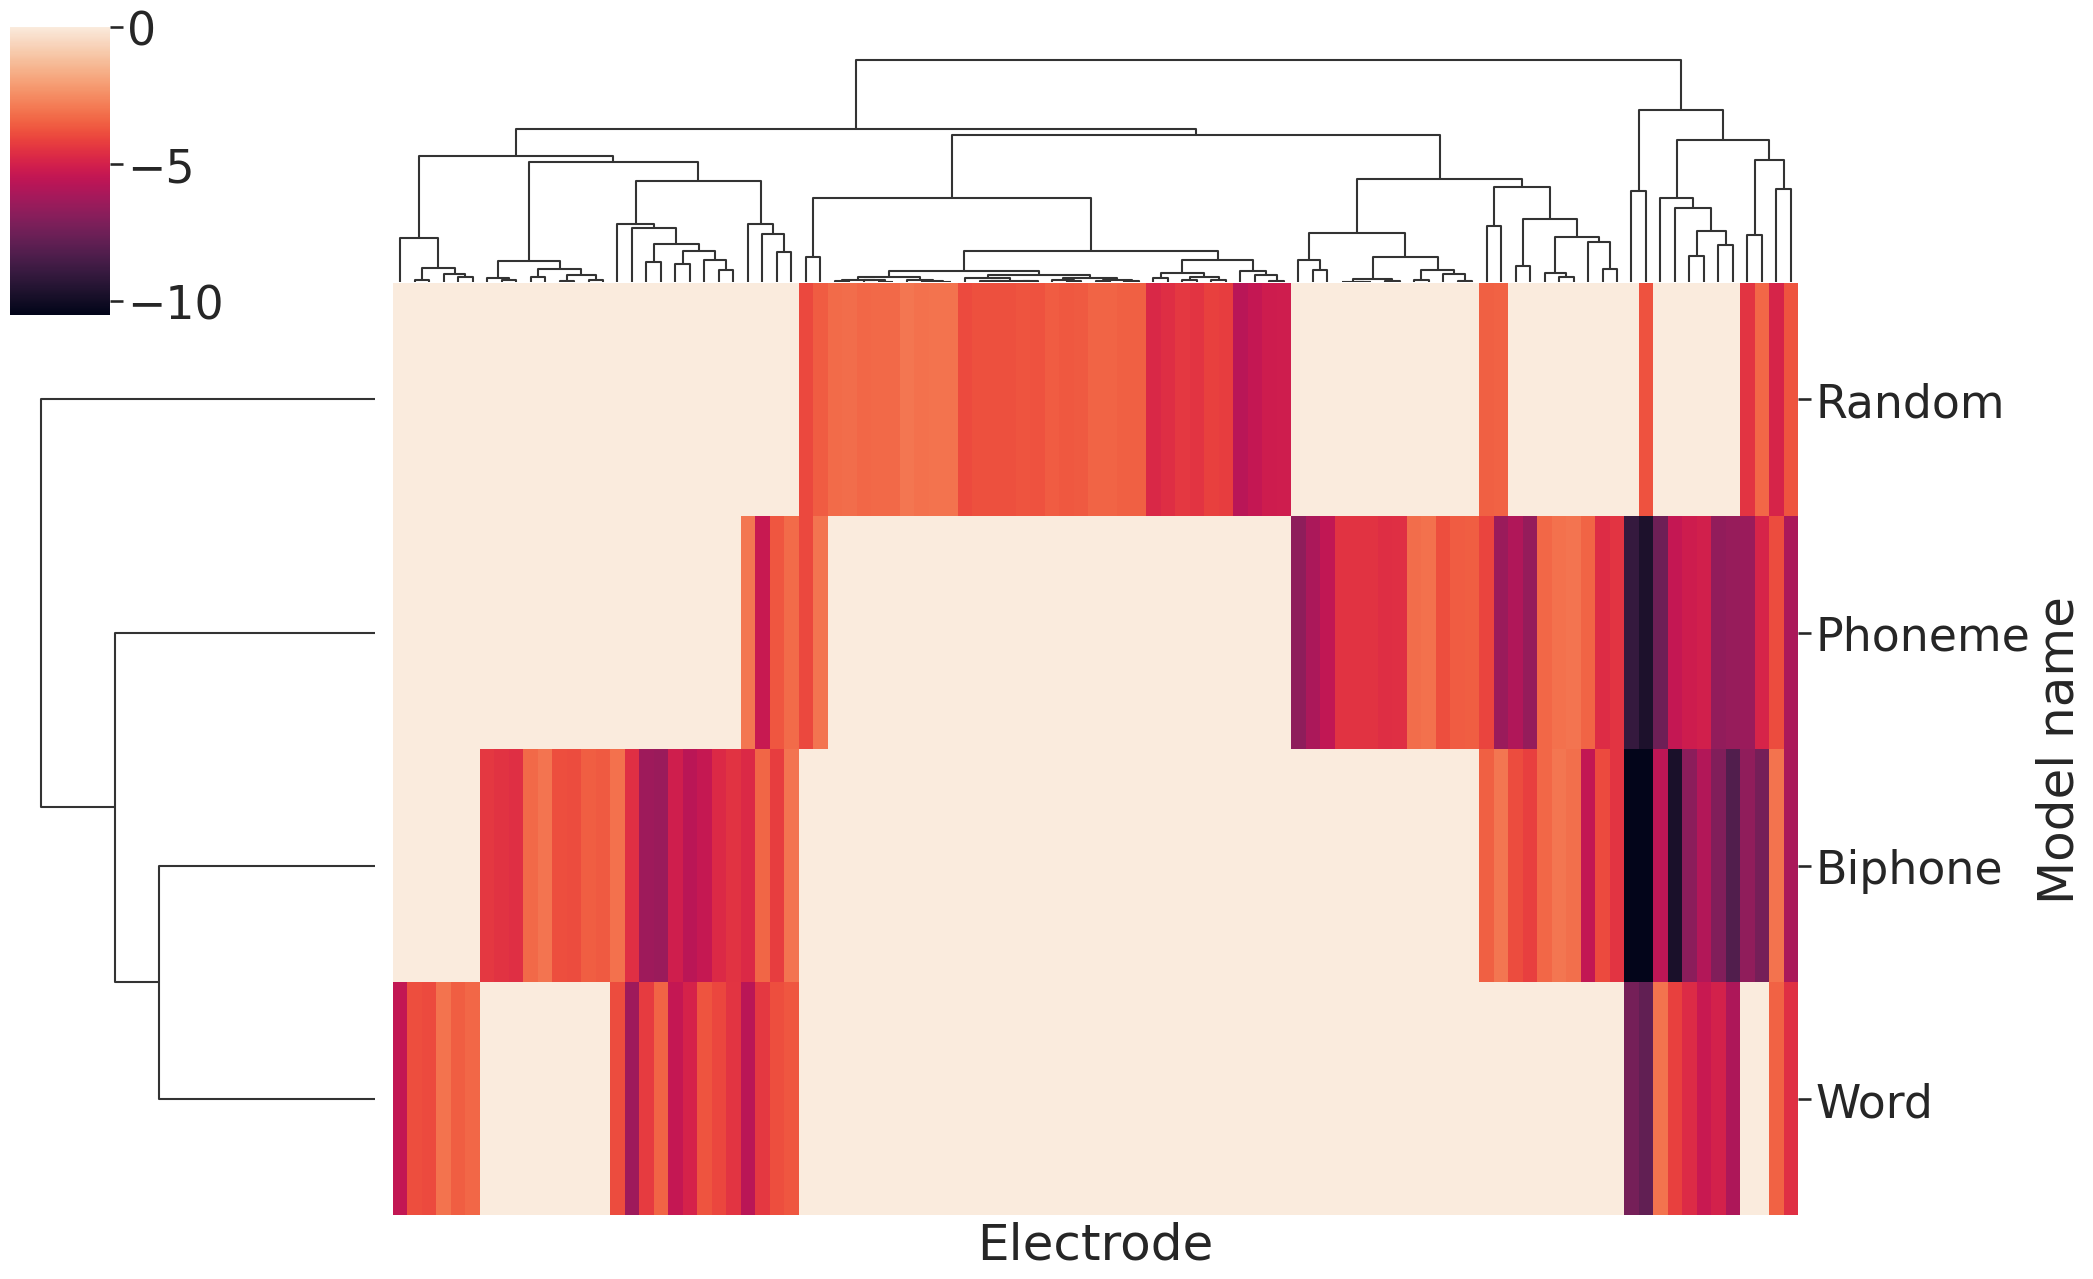

In [39]:
g = sns.clustermap(log_pvals, vmax=0, xticklabels=1, figsize=(20, 16), tree_kws=dict(linewidths=1.5))
g.ax_heatmap.set_xlabel("Electrode")
g.ax_heatmap.set_ylabel("Model name")
g.ax_heatmap.set_xticks([])
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

## Colocation

### Colocation of baseline predictiveness and model improvement

In [75]:
score_relationship = scores_df \
    .assign(model=scores_df.model.replace({model_name: "full_model" for model_name in set(scores_df.model) - {"baseline"}})) \
    .reset_index().pivot(index=["subject", "model2", "output_dim", "fold"], columns="model", values="score")
score_relationship

model                                             baseline  full_model
subject model2                   output_dim fold                      
EC152   biphone_recon            0          0    -0.001135   -0.002244
                                            1    -0.001564   -0.002879
                                            2    -0.007084   -0.007947
                                 1          0     0.001129    0.002168
                                            1     0.002411    0.002080
...                                                    ...         ...
EC260   word_broad-aniso2-w2v2_8 254        1     0.061153    0.060345
                                            2     0.047459    0.047571
                                 255        0     0.076003    0.075873
                                            1     0.055240    0.054914
                                            2     0.046608    0.046319

[19968 rows x 2 columns]

In [76]:
# merge in significance values
score_relationship = pd.merge(
    score_relationship, ttest_filtered_df[["pval"]],
    how="left", left_index=True, right_index=True)
score_relationship["significant_improvement"] = score_relationship.pval < pval_threshold

In [77]:
# merge in electrode ROI information
score_relationship = pd.merge(score_relationship.reset_index(),
                              electrode_df[["roi"]].reset_index(),
                              how="left",
                              left_on=["subject", "output_dim"],
                              right_on=["subject", "electrode_idx"]).drop(columns=["electrode_idx"]) \
    .set_index(["subject", "model2", "output_dim", "fold"])

In [78]:
score_relationship["model_name"] = score_relationship.index.get_level_values("model2").map(study_model_code_to_name)

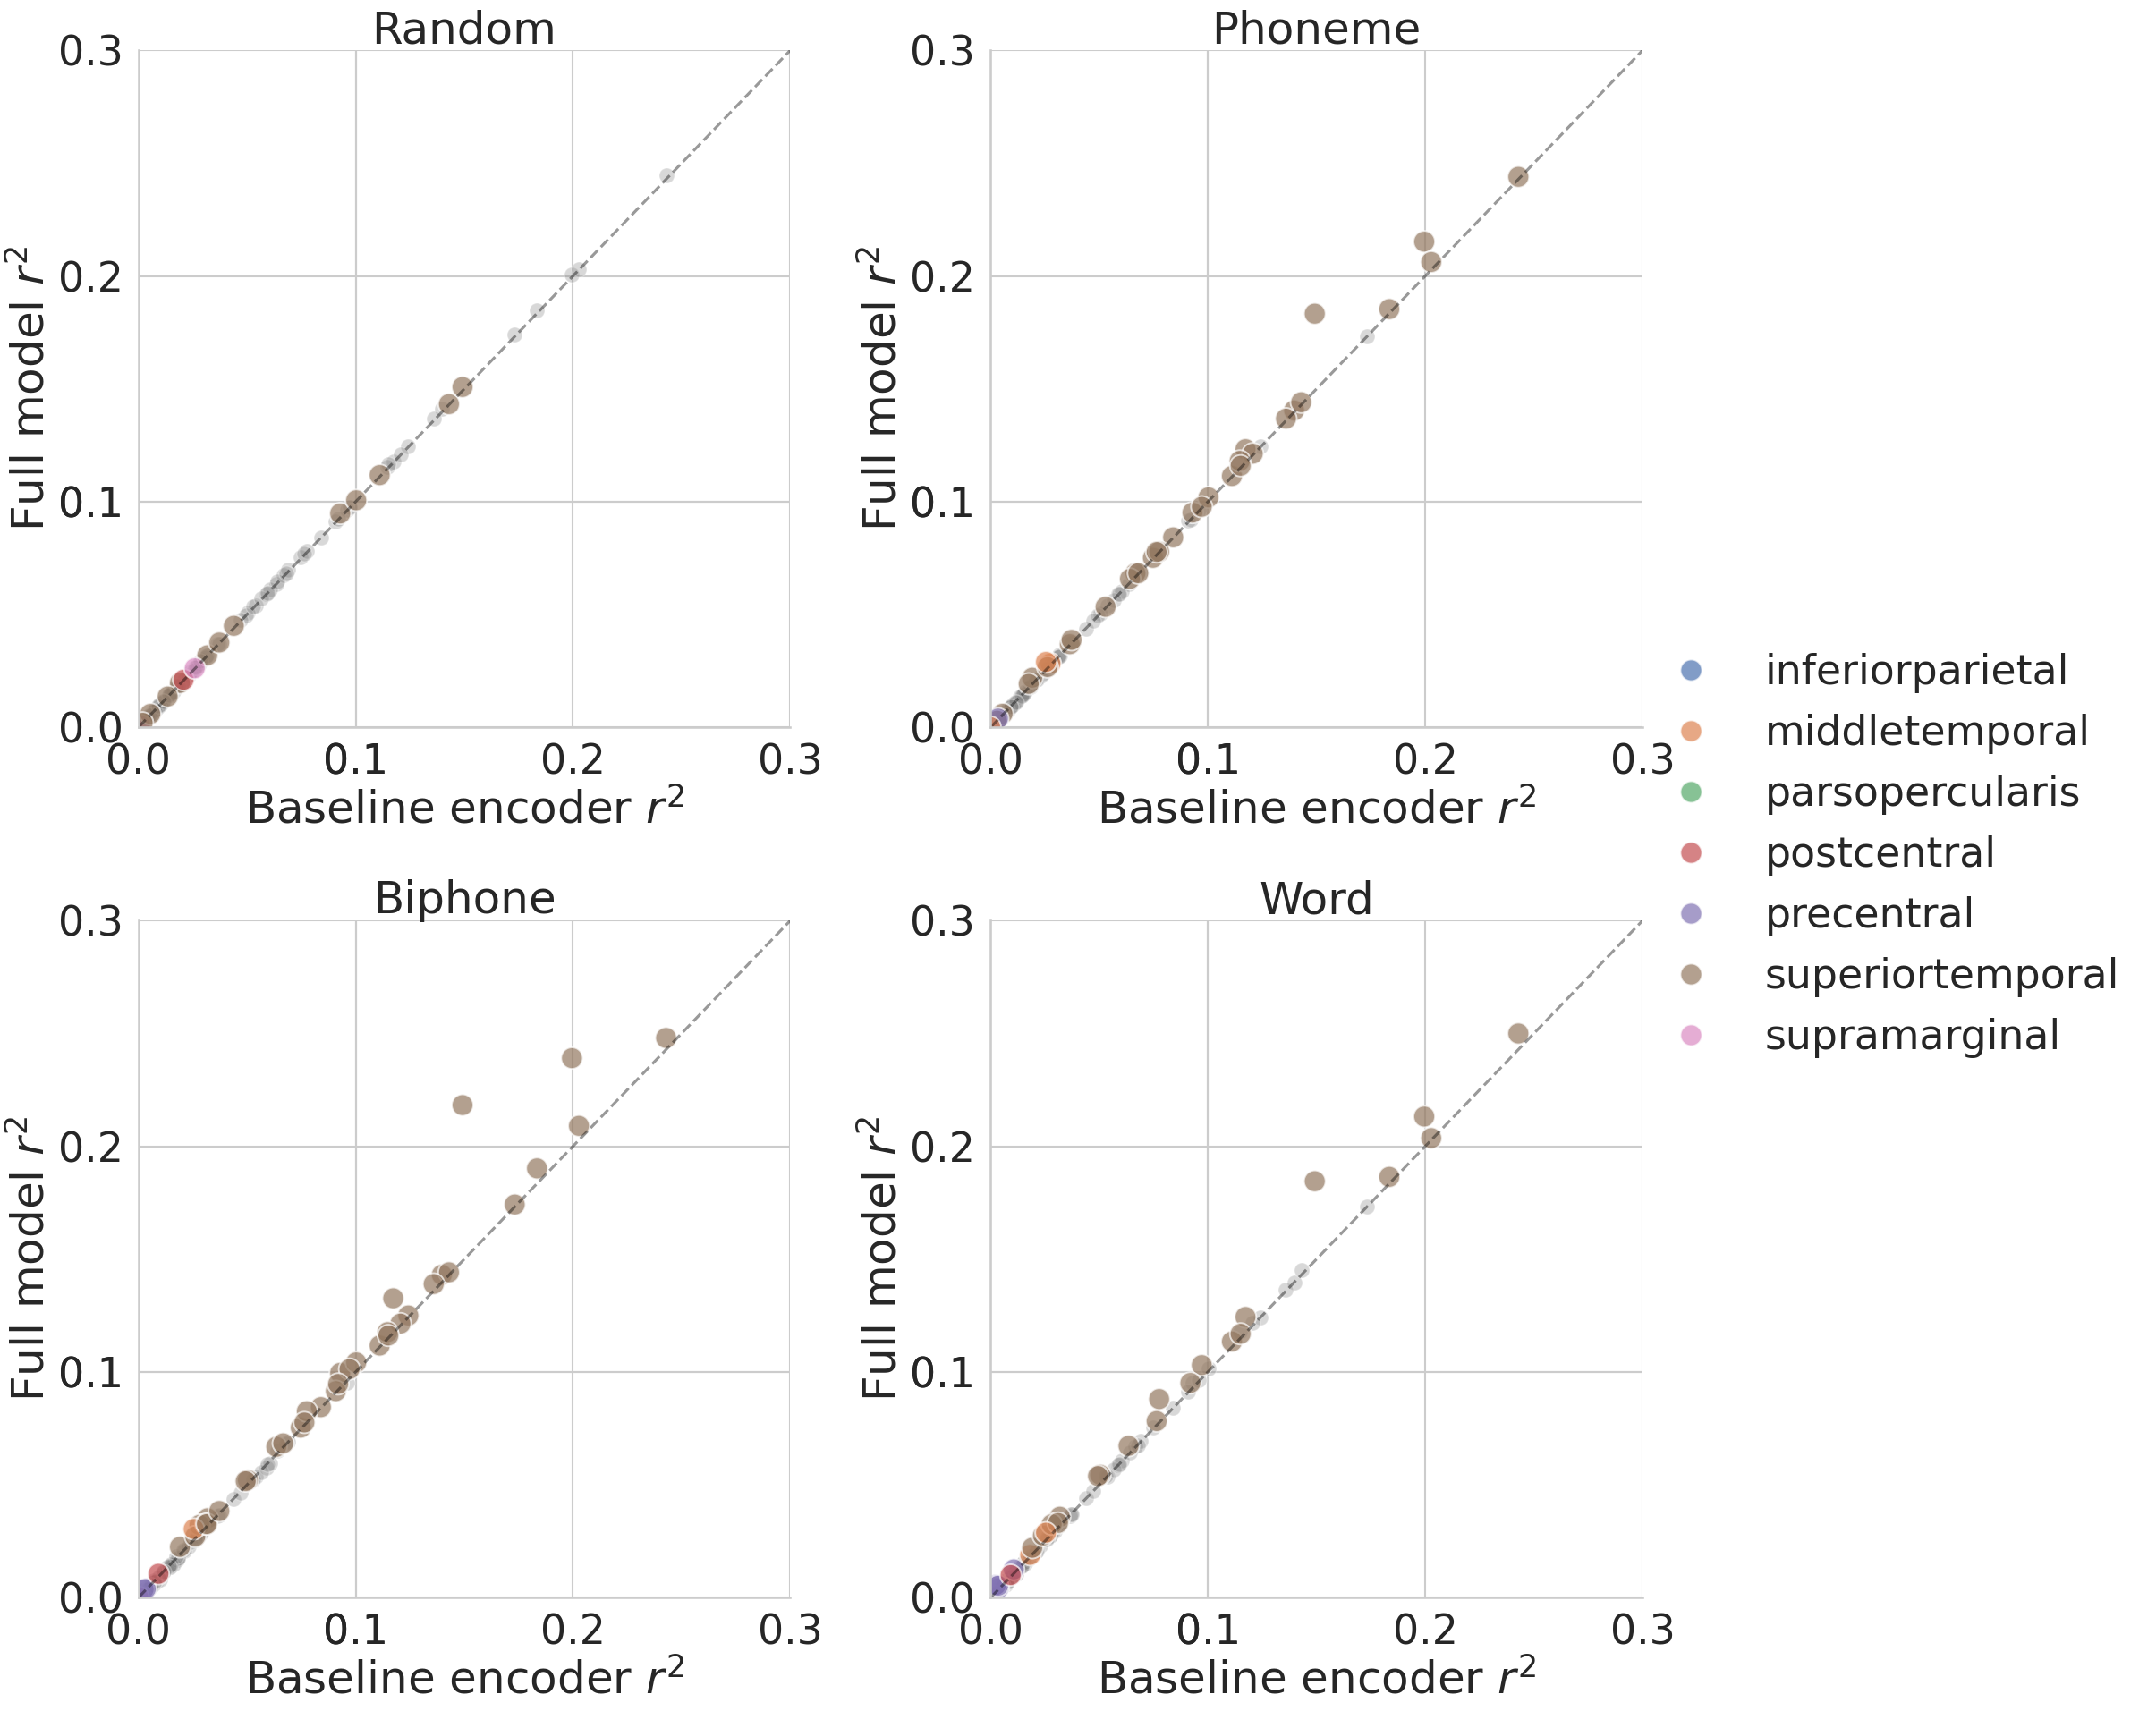

In [221]:
# manually FacetGrid so we can plot two disjoint parts of score_relationship -- those which are not
# significant, and those which are
plot_score_relationship = score_relationship.loc[plot_subjects]
# average scores over folds; take boolean AND over folds for significance
plot_score_relationship = plot_score_relationship.groupby(["subject", "model_name", "output_dim", "roi"]) \
    .agg({"significant_improvement": "all", "baseline": "mean", "full_model": "mean"}).reset_index()
plot_score_relationship = plot_score_relationship.loc[(plot_score_relationship.full_model > 0)]
g = sns.FacetGrid(data=plot_score_relationship.reset_index(),
                  col="model_name", col_wrap=2, col_order=study_models.keys(),
                  sharex=False, sharey=False, height=10)

# prepare ROI hues
hue_order = sorted(plot_score_relationship.roi.unique())

def plot_significant_elecs(data, **kwargs):
    ax = plt.gca()
    sns.scatterplot(data=data[data.significant_improvement],
                    x="baseline", y="full_model", hue="roi", hue_order=hue_order,\
                    alpha=0.7, s=300, ax=ax)
    
def plot_nonsignificant_elecs(data, **kwargs):
    ax = plt.gca()
    sns.scatterplot(data=data[~data.significant_improvement],
                    x="baseline", y="full_model", color="gray",
                    alpha=0.3, s=150, ax=ax)

g.map_dataframe(plot_nonsignificant_elecs)
g.map_dataframe(plot_significant_elecs)
g.add_legend()

ax_min = 0.
ax_max = plot_score_relationship[["baseline", "full_model"]].max().max() + 0.01
for ax in g.axes.ravel():
    ax.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.4)
    ax.set_xlim(ax_min, ax_max)
    ax.set_ylim(ax_min, ax_max)

    ticks = (np.linspace(ax_min, ax_max, 5) * 10).round() / 10.
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(ax.get_title().replace("model_name = ", ""))
    ax.set_xlabel("Baseline encoder $r^2$")
    ax.set_ylabel("Full model $r^2$")

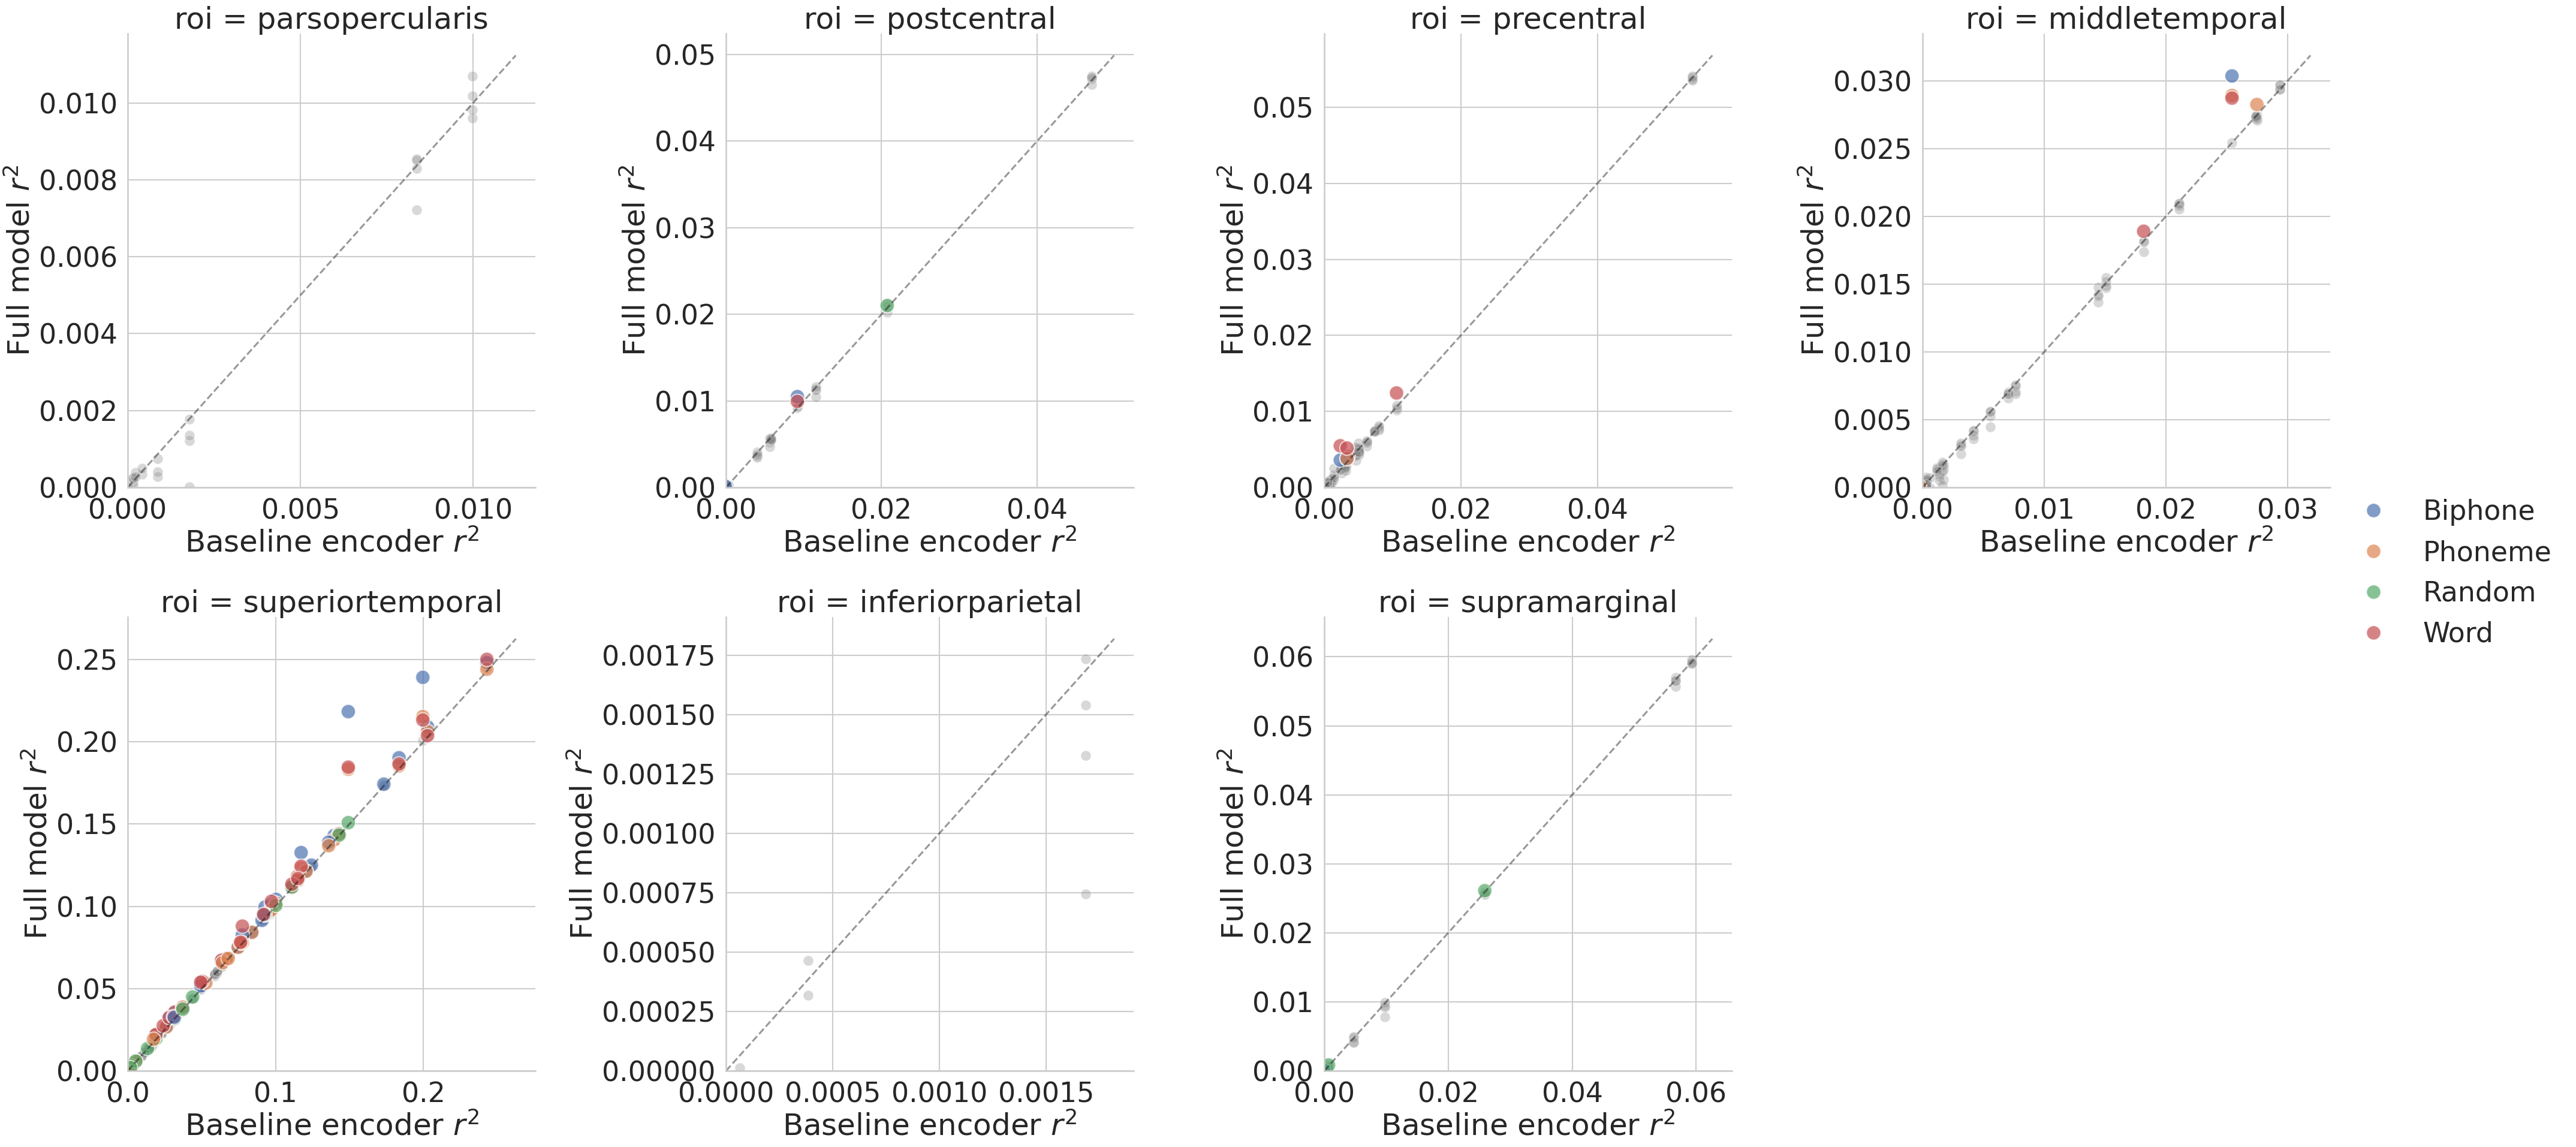

In [226]:
# manually FacetGrid so we can plot two disjoint parts of score_relationship -- those which are not
# significant, and those which are
plot_score_relationship = score_relationship.loc[plot_subjects]
# average scores over folds; take boolean AND over folds for significance
plot_score_relationship = plot_score_relationship.groupby(["subject", "model_name", "output_dim", "roi"]) \
    .agg({"significant_improvement": "all", "baseline": "mean", "full_model": "mean"}).reset_index()
plot_score_relationship = plot_score_relationship.loc[(plot_score_relationship.full_model > 0)]
g = sns.FacetGrid(data=plot_score_relationship.reset_index(),
                  col="roi", col_wrap=4, #col_order=study_models.keys(),
                  sharex=False, sharey=False, height=10)

# prepare ROI hues
hue_order = sorted(plot_score_relationship.model_name.unique())

def plot_significant_elecs(data, **kwargs):
    ax = plt.gca()
    sns.scatterplot(data=data[data.significant_improvement],
                    x="baseline", y="full_model", hue="model_name", hue_order=hue_order,
                    alpha=0.7, s=300, ax=ax)
    
def plot_nonsignificant_elecs(data, **kwargs):
    ax = plt.gca()
    sns.scatterplot(data=data[~data.significant_improvement],
                    x="baseline", y="full_model", color="gray",
                    alpha=0.3, s=150, ax=ax)

g.map_dataframe(plot_nonsignificant_elecs)
g.map_dataframe(plot_significant_elecs)
g.add_legend()

ax_min = 0.
ax_max = plot_score_relationship[["baseline", "full_model"]].max().max() + 0.01
for ax in g.axes.ravel():
    line_end = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([0, line_end], [0, line_end], color="black", linestyle="--", alpha=0.4)

    ax.set_xlim((0, ax.get_xlim()[1]))
    ax.set_ylim((0, ax.get_ylim()[1]))
    # ticks = (np.linspace(ax_min, ax_max, 5) * 10).round() / 10.
    # ax.set_xticks(ticks)
    # ax.set_yticks(ticks)
    ax.set_title(ax.get_title().replace("model_name = ", ""))
    ax.set_xlabel("Baseline encoder $r^2$")
    ax.set_ylabel("Full model $r^2$")

In [242]:
significant_improvements = plot_score_relationship.groupby(["subject", "model_name", "output_dim", "roi"]).filter(lambda xs: xs.significant_improvement.all()) \
    .groupby(["subject", "model_name", "output_dim", "roi"]).head(1)

print(significant_improvements.groupby(["subject", "model_name"]).size() / electrode_df.groupby("subject").size())
print(significant_improvements.groupby(["model_name"]).size())

# take just one model (if any) per output dim; then get the number of electrodes per ROI showing improvement
# under any model
print("# electrodes by ROI showing improvement under at least 1 model:")
print(significant_improvements.groupby(["subject", "roi", "output_dim"]).head(1).groupby(["subject", "roi"]).size())
print((significant_improvements.groupby(["subject", "roi", "output_dim"]).head(1).groupby(["subject", "roi"]).size() / electrode_df.groupby(["subject", "roi"]).size()).dropna())

subject  model_name
EC212    Biphone       0.058190
         Phoneme       0.047414
         Random        0.019397
         Word          0.036638
EC260    Biphone       0.044025
         Phoneme       0.040881
         Random        0.018868
         Word          0.031447
dtype: float64
model_name
Biphone    41
Phoneme    35
Random     15
Word       27
dtype: int64
# electrodes by ROI showing improvement under at least 1 model:
subject  roi             
EC212    middletemporal       2
         postcentral          1
         precentral           2
         superiortemporal    31
         supramarginal        2
EC260    middletemporal       2
         postcentral          2
         precentral           2
         superiortemporal    16
         supramarginal        1
dtype: int64
subject  roi             
EC212    middletemporal      0.026667
         postcentral         0.028571
         precentral          0.045455
         superiortemporal    0.442857
         supramarginal      

/tmp/ipykernel_2746198/1565745232.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35, horizontalalignment="right")


[Text(0, 0, 'middletemporal'),
 Text(1, 0, 'postcentral'),
 Text(2, 0, 'precentral'),
 Text(3, 0, 'superiortemporal'),
 Text(4, 0, 'supramarginal')]

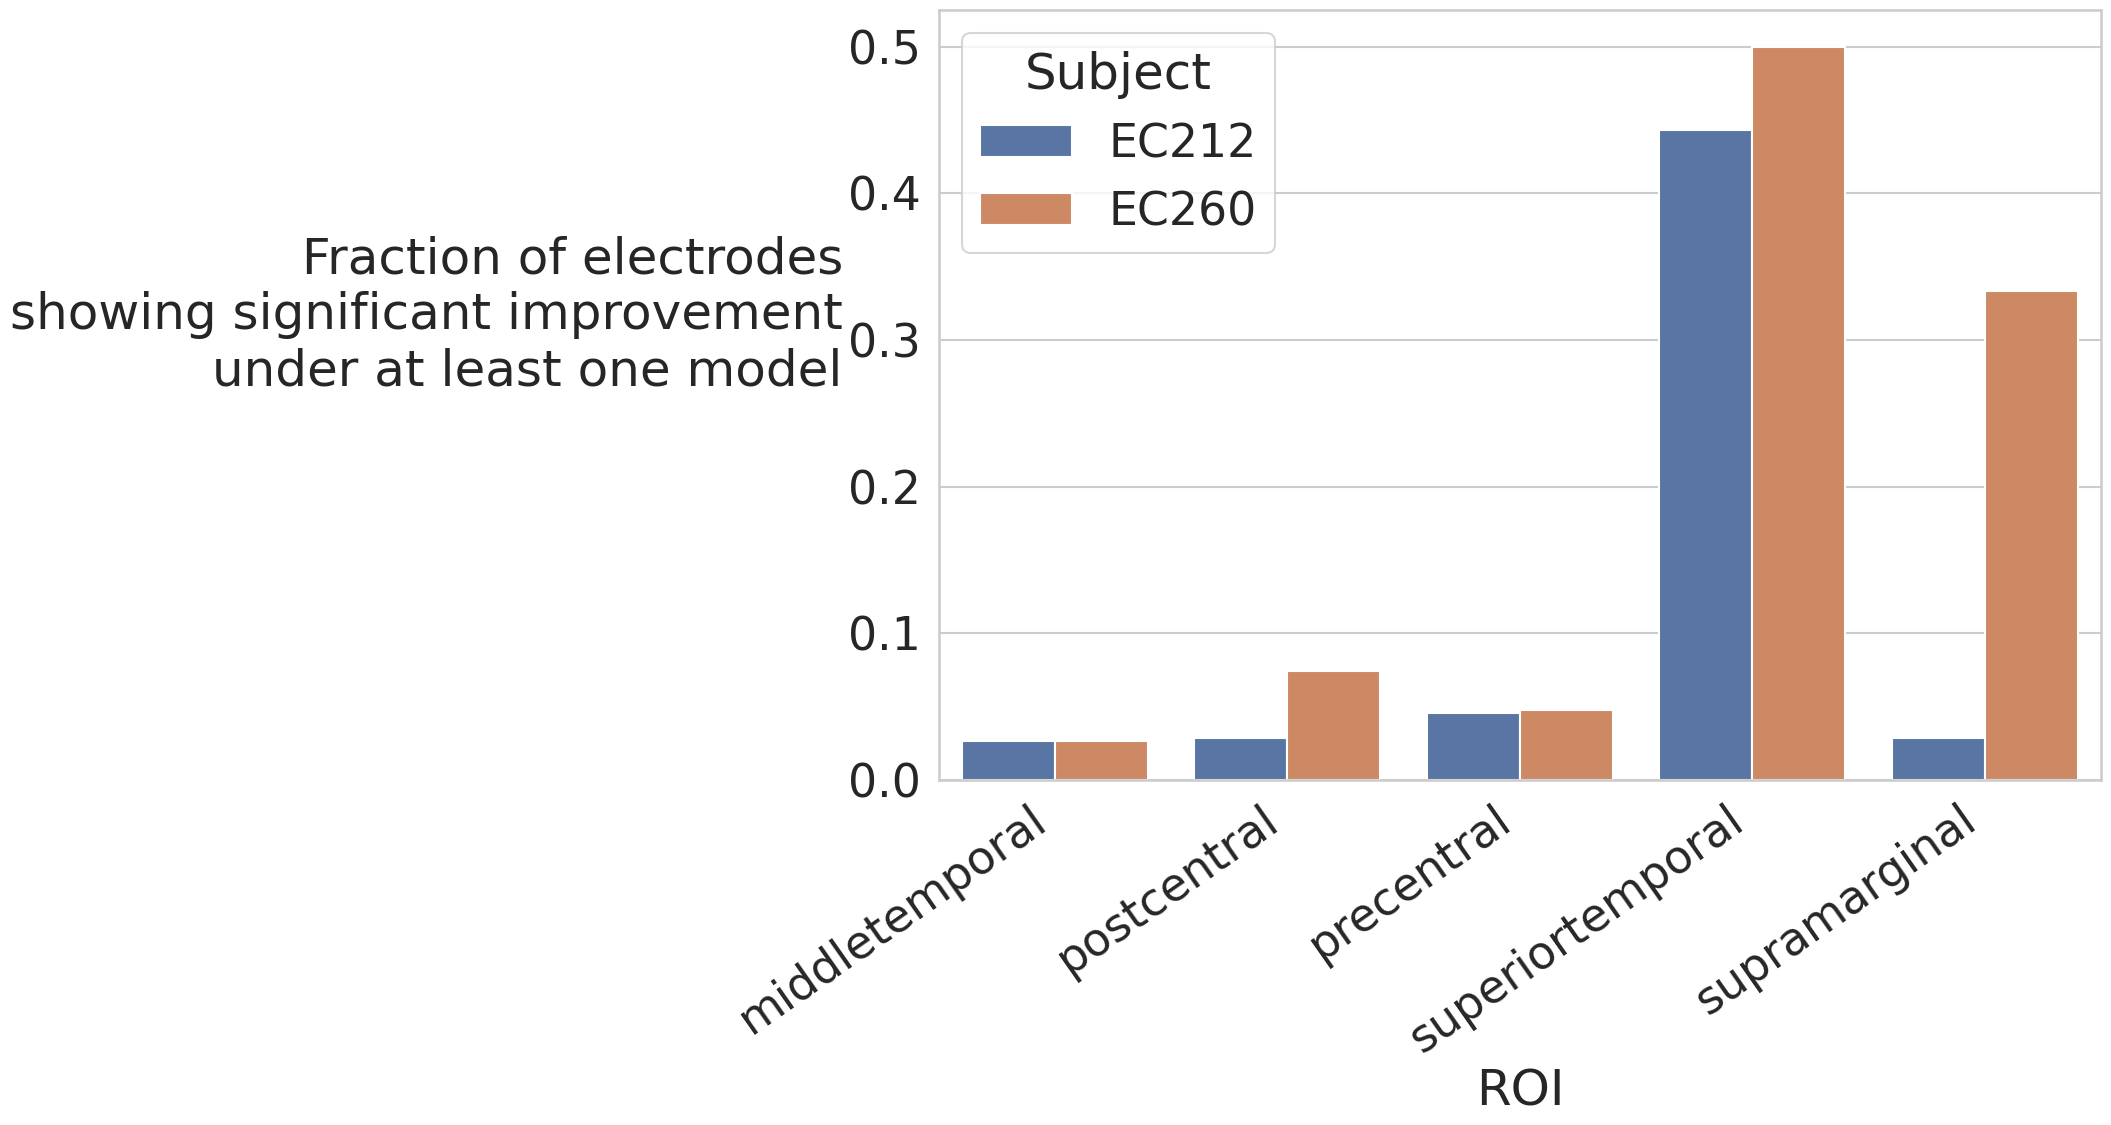

In [251]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=(significant_improvements.groupby(["subject", "roi", "output_dim"]).head(1)
                  .groupby(["subject", "roi"]).size() / electrode_df.groupby(["subject", "roi"]).size()).dropna().rename("pct_improved").reset_index(),
            x="roi", y="pct_improved", hue="subject",
            ax=ax)
ax.get_legend().set_title("Subject")
ax.set_ylabel("Fraction of electrodes\nshowing significant improvement\nunder at least one model",
              ma="right", ha="right", rotation=0)
ax.set_xlabel("ROI")
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, horizontalalignment="right")

In [234]:
plot_score_relationship

,subject,model_name,output_dim,roi,significant_improvement,baseline,full_model
1,EC212,Biphone,1,parsopercularis,False,0.001784,0.000017
17,EC212,Biphone,17,parsopercularis,False,0.009976,0.009602
29,EC212,Biphone,29,postcentral,True,-0.000094,0.000146
33,EC212,Biphone,33,parsopercularis,False,0.008370,0.007218
76,EC212,Biphone,76,precentral,False,0.002580,0.001906
...,...,...,...,...,...,...,...
2551,EC260,Word,247,postcentral,True,0.009184,0.009939
2556,EC260,Word,252,superiortemporal,False,0.002144,0.001828
2557,EC260,Word,253,supramarginal,False,0.025905,0.025654
2558,EC260,Word,254,supramarginal,False,0.056687,0.056554


Text(0.5, 47.44444444444447, '$\\log_{10}$-improvement in $r^2$')

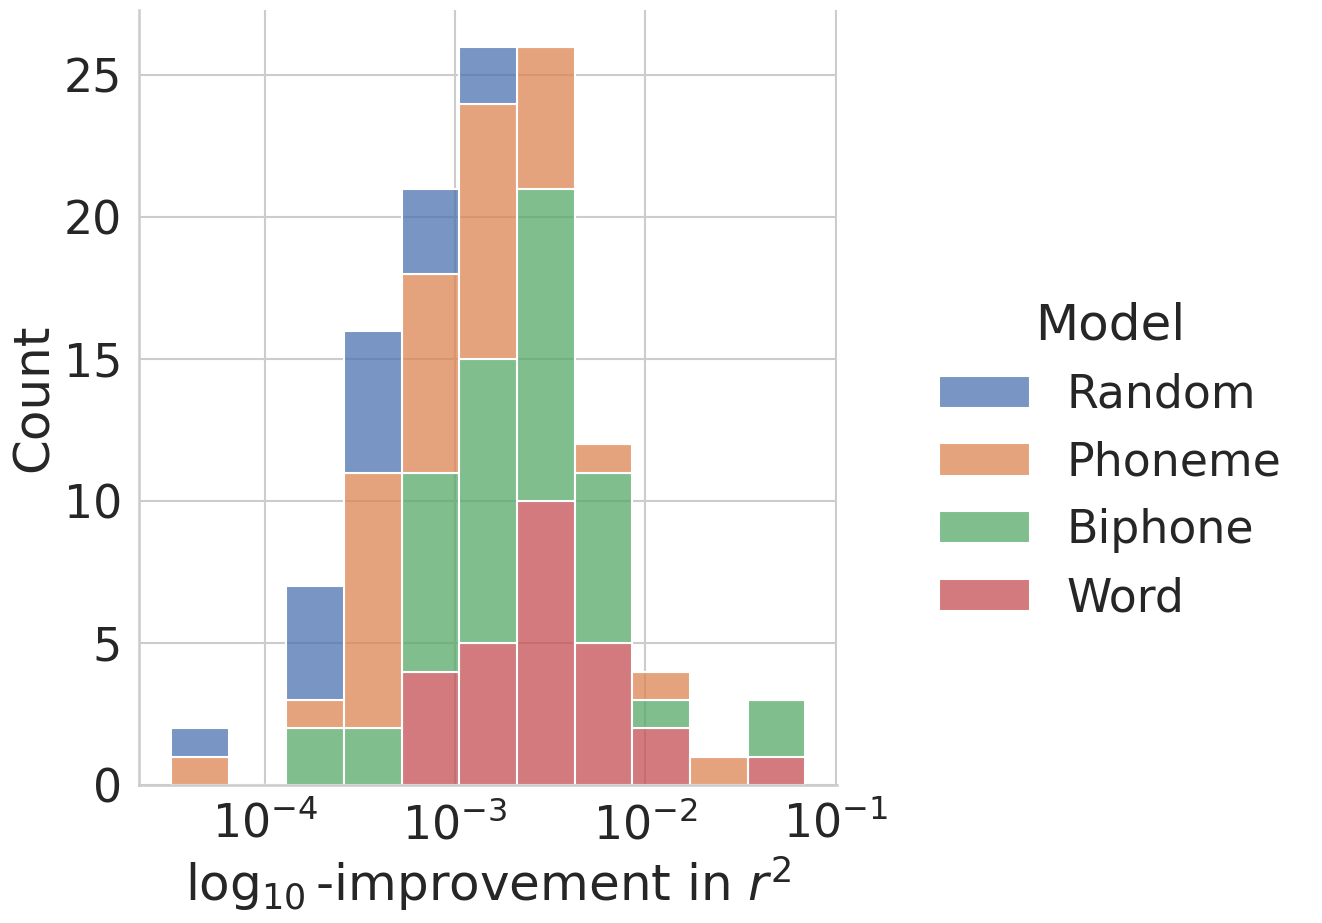

In [353]:
improvement_df = plot_score_relationship[plot_score_relationship.significant_improvement].set_index(["subject", "model_name", "output_dim"])
improvement_df = (improvement_df.full_model - improvement_df.baseline) \
                .groupby(["subject", "model_name", "output_dim"]).mean().rename("improvement").reset_index()
g = sns.displot(data=improvement_df, log_scale=10,
                x="improvement", hue="model_name", hue_order=study_models.keys(),
                multiple="stack", height=10)
g.legend.set_title("Model")
g.ax.set_xlabel("$\log_{10}$-improvement in $r^2$")

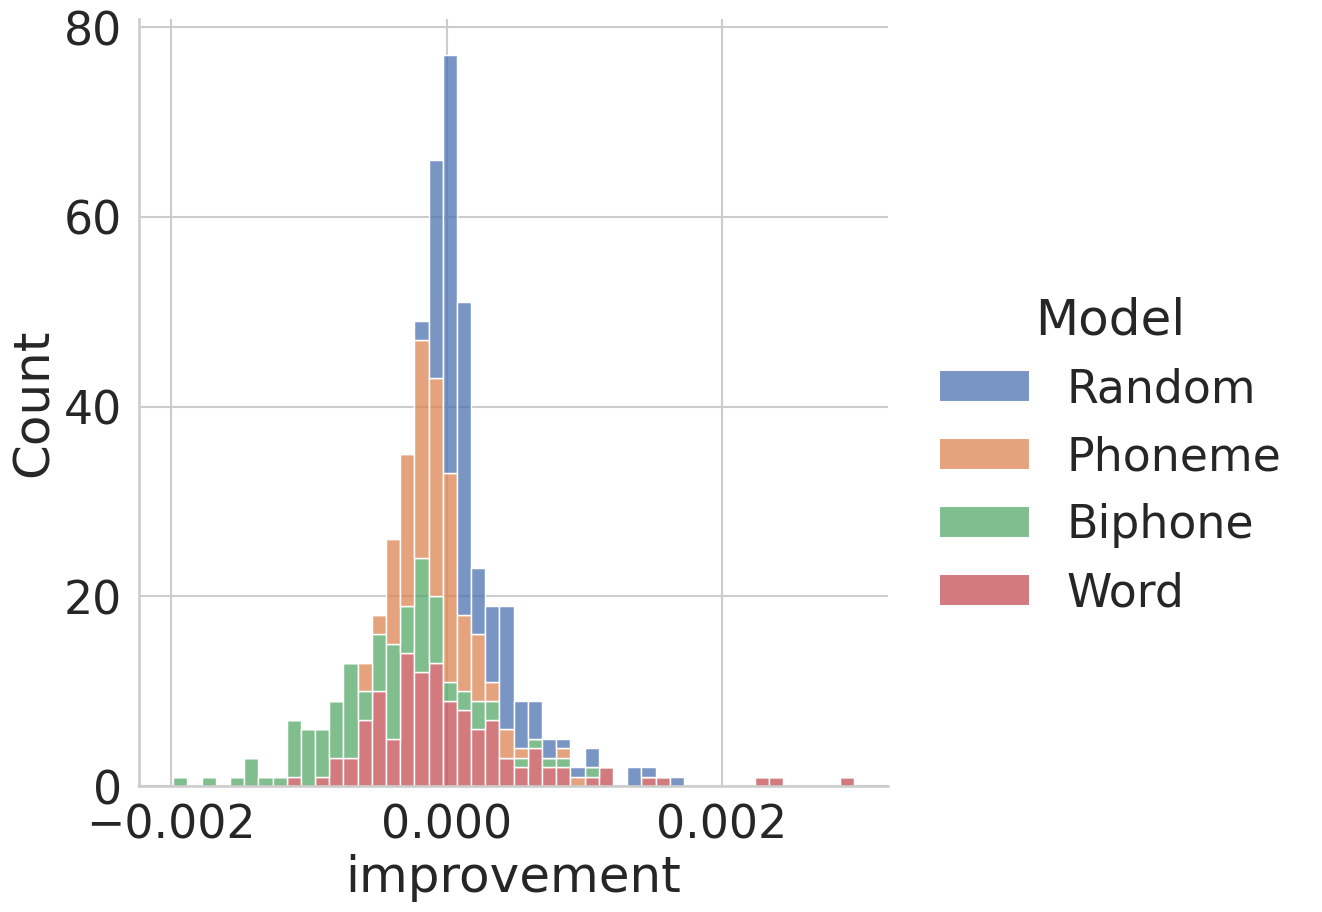

In [239]:
improvement_df = plot_score_relationship[~plot_score_relationship.significant_improvement].set_index(["subject", "model_name", "output_dim"])
improvement_df = (improvement_df.full_model - improvement_df.baseline) \
                .groupby(["subject", "model_name", "output_dim"]).mean().rename("improvement").reset_index()
g = sns.displot(data=improvement_df,
                x="improvement", hue="model_name", hue_order=study_models.keys(),
                multiple="stack", height=10)
g.legend.set_title("Model")
            

In [120]:
plot_score_relationship.groupby("roi").significant_improvement.sum()

roi
caudalmiddlefrontal       2
inferiorparietal          1
lateraloccipital          0
middletemporal           18
parsopercularis           0
parstriangularis          0
postcentral              11
precentral               21
rostralmiddlefrontal      0
superiortemporal        292
supramarginal            12
Name: significant_improvement, dtype: int64

### Colocation of model embedding and baseline predictivity

In [81]:
model_embedding_improvements = (score_relationship.full_model - score_relationship.baseline).unstack("model2").groupby(["subject", "output_dim"]).mean()
# not interested in overfit electrodes
model_embedding_improvements[model_embedding_improvements < 0] = np.nan
model_embedding_improvements

model2              biphone_recon   phoneme   random8  \
subject output_dim                                      
EC152   0                     NaN       NaN       NaN   
        1                0.000612  0.000164  0.000070   
        2                     NaN       NaN       NaN   
        3                     NaN       NaN  0.000106   
        4                     NaN       NaN  0.000073   
...                           ...       ...       ...   
EC260   251                   NaN  0.000210       NaN   
        252                   NaN       NaN       NaN   
        253                   NaN       NaN  0.000209   
        254                   NaN       NaN  0.000347   
        255                   NaN       NaN  0.000348   

model2              word_broad-aniso2-w2v2_8  
subject output_dim                            
EC152   0                                NaN  
        1                            0.00027  
        2                                NaN  
        3                                NaN  
        4                                NaN  
...                                      ...  
EC260   251                              NaN  
        252                              NaN  
        253                              NaN  
        254                              NaN  
        255                              NaN  

[1664 rows x 4 columns]

In [82]:
baseline_feature_improvements = unique_variance.unstack("dropped_feature").groupby(["subject", "output_dim"]).mean()
# not interested in overfit electrodes
baseline_feature_improvements[baseline_feature_improvements < 0] = np.nan
baseline_feature_improvements

dropped_feature           F0  formantMedOnset    maxDtL     onset  \
subject output_dim                                                  
EC152   0           0.000702              NaN       NaN  0.000008   
        1                NaN         0.000245       NaN       NaN   
        2           0.002554              NaN       NaN       NaN   
        3                NaN              NaN       NaN  0.000046   
        4                NaN              NaN  0.000065       NaN   
...                      ...              ...       ...       ...   
EC260   251              NaN              NaN  0.000011       NaN   
        252         0.001315              NaN       NaN  0.000096   
        253         0.013847         0.000178  0.000032  0.000444   
        254         0.026141         0.000182  0.000012  0.000928   
        255         0.026798         0.000484  0.000033  0.001020   

dropped_feature     phnfeatConsOnset  
subject output_dim                    
EC152   0                   0.000508  
        1                        NaN  
        2                        NaN  
        3                   0.000317  
        4                   0.000164  
...                              ...  
EC260   251                      NaN  
        252                 0.000199  
        253                 0.001263  
        254                 0.001257  
        255                 0.001861  

[1664 rows x 5 columns]

Text(0, 0.5, 'Unique variance $\\Delta r^2$')

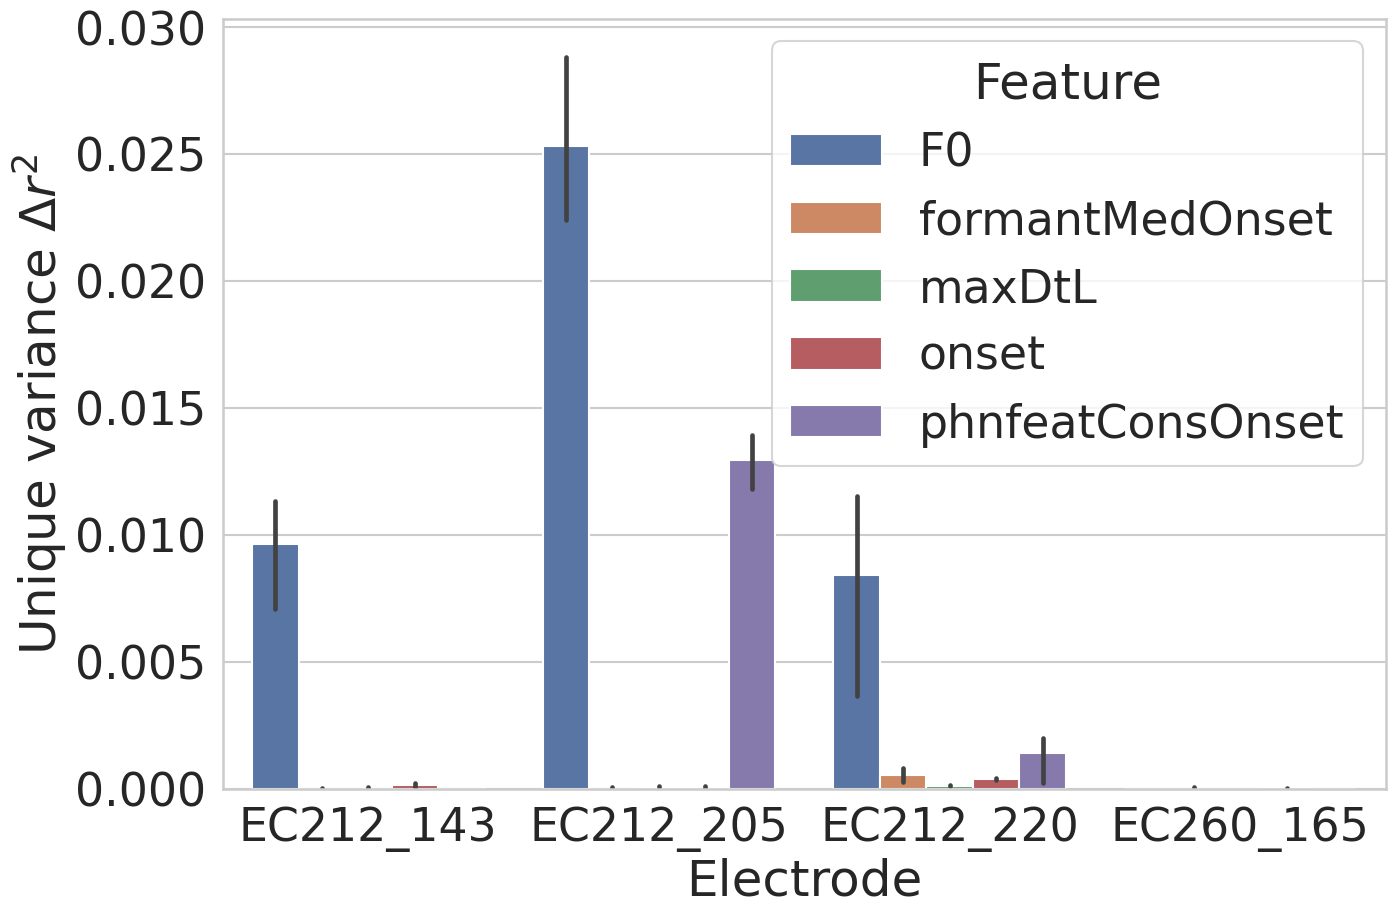

In [388]:
plot_unique_variance = unique_variance.unstack("dropped_feature")
plot_unique_variance.index = plot_unique_variance.index.reorder_levels(["subject", "output_dim", "fold"])
plot_unique_variance = plot_unique_variance.reset_index("fold").loc[[
    ("EC212", 143),
    ("EC212", 205),
    ("EC212", 220),
    ("EC260", 165),
]].reset_index()
plot_unique_variance["electrode_label"] = plot_unique_variance.subject.str.cat(plot_unique_variance.output_dim.astype(str), sep="_")
plot_unique_variance = plot_unique_variance.drop(columns=["subject", "output_dim"]).melt(id_vars=["electrode_label", "fold"])

f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=plot_unique_variance,
            x="electrode_label", hue="dropped_feature", y="value")
ax.set_ylim((0, ax.get_ylim()[1]))
ax.get_legend().set_title("Feature")
ax.set_xlabel("Electrode")
ax.set_ylabel("Unique variance $\Delta r^2$")

In [395]:
speech_responsive_electrodes = score_relationship[["baseline", "full_model"]].max(axis=1).groupby(["subject", "model2", "output_dim"]).mean() \
    .groupby(["subject", "output_dim"]).max()
speech_responsive_electrodes = speech_responsive_electrodes[speech_responsive_electrodes > 0.025].index

Text(2271.7916666666665, 0.5, 'Baseline feature')

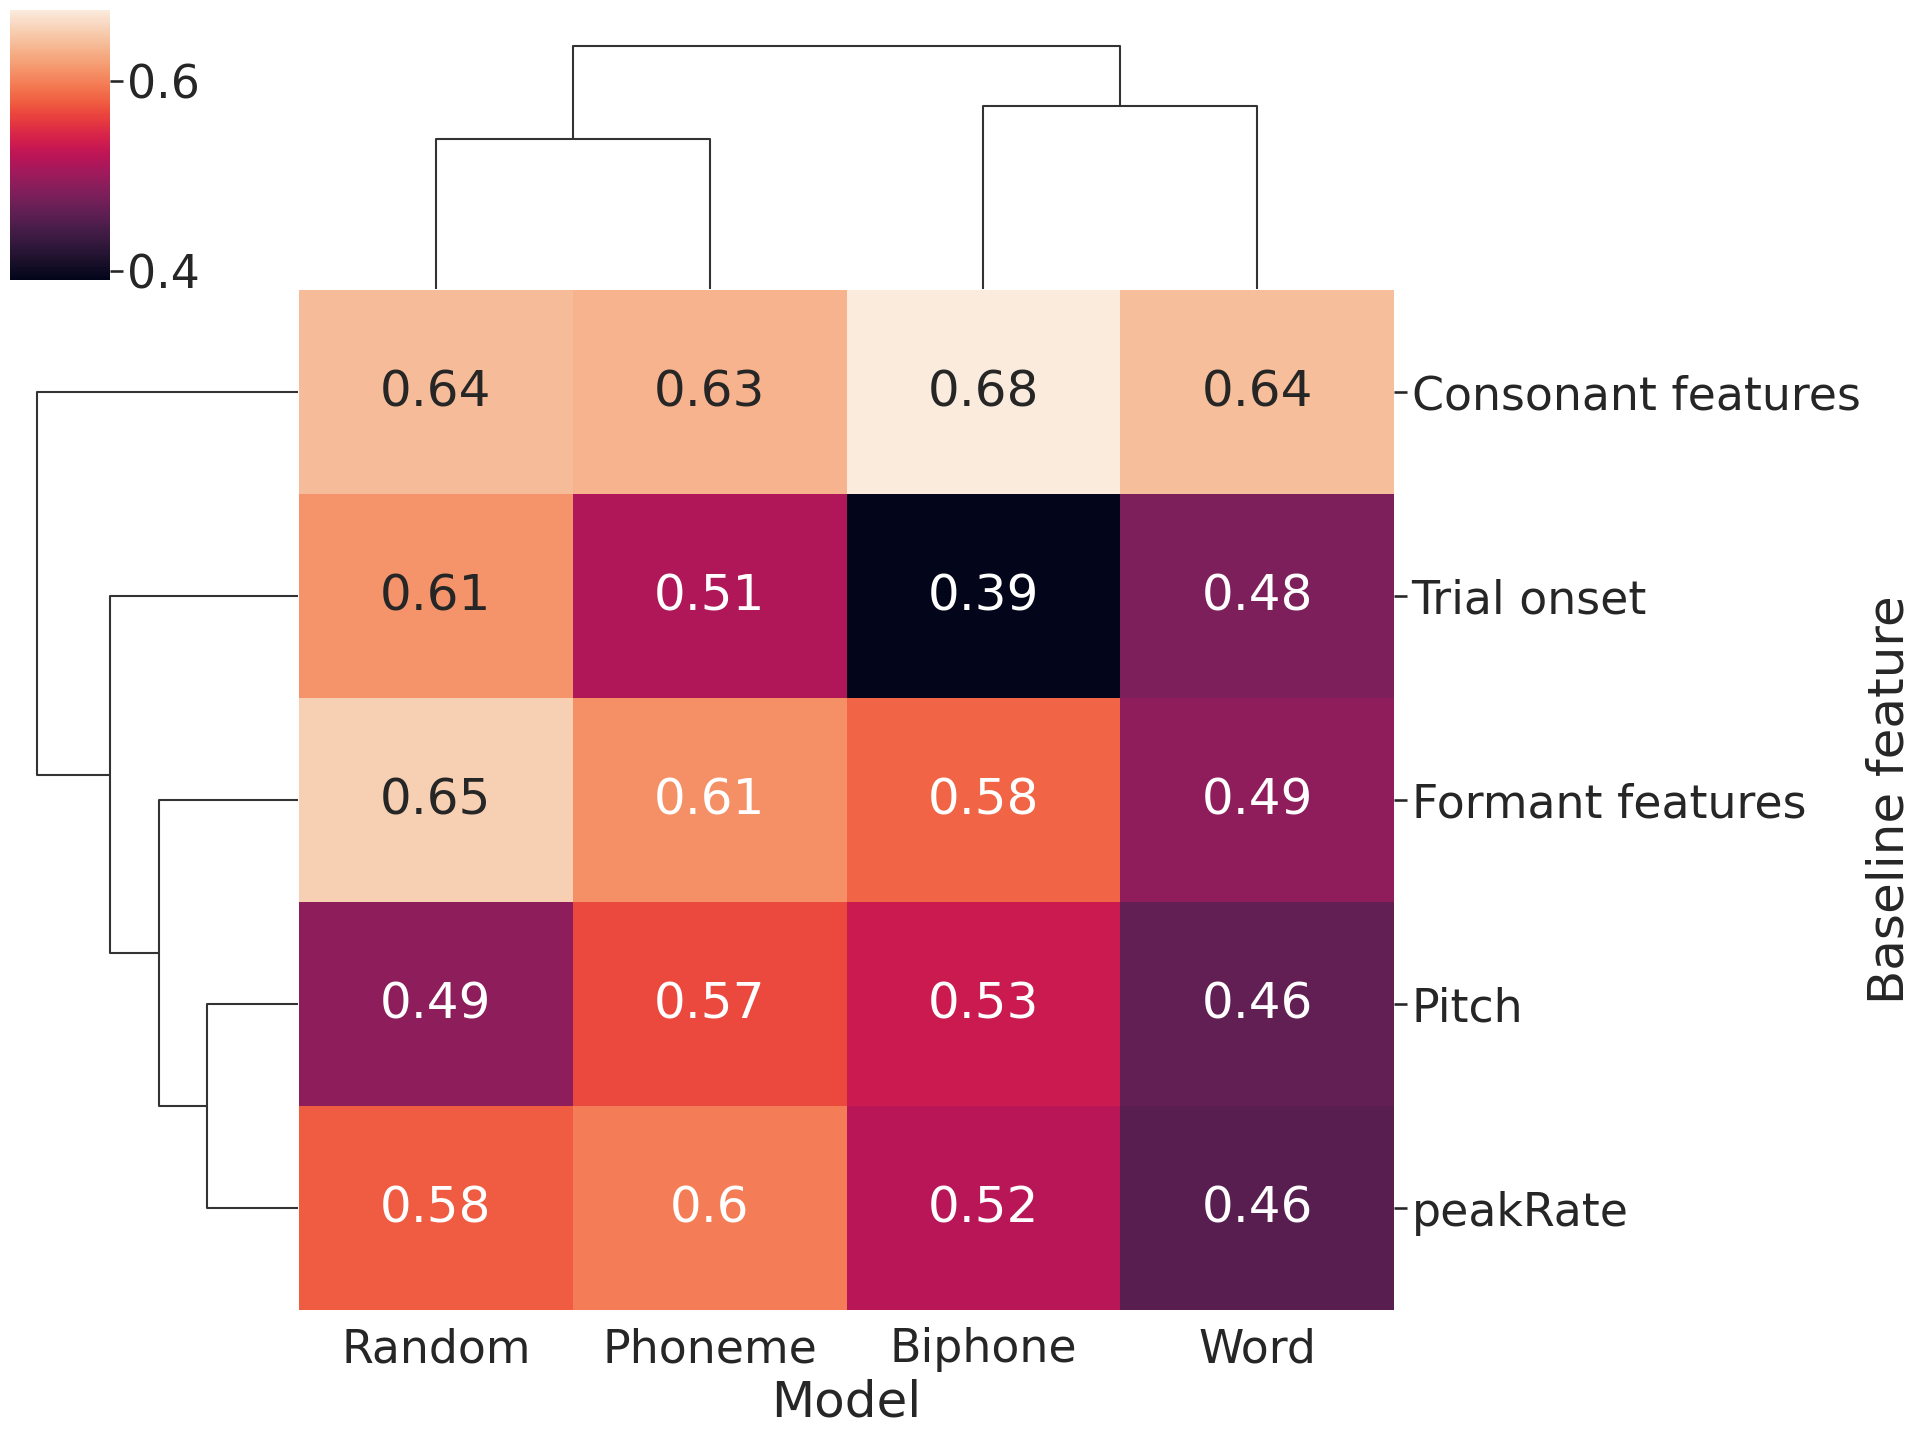

In [256]:
improvement_correlations = pd.concat([model_embedding_improvements, baseline_feature_improvements], axis=1) \
                 .corr("spearman").loc[baseline_feature_improvements.columns, model_embedding_improvements.columns]
improvement_correlations.columns = improvement_correlations.columns.map(study_model_code_to_name)
improvement_correlations.index = improvement_correlations.index.map(interpretable_feature_names)
g = sns.clustermap(improvement_correlations[list(study_models.keys())], tree_kws=dict(linewidth=1.5),
               figsize=(20, 15), annot=True)
g.ax_heatmap.set_xlabel("Model")
g.ax_heatmap.set_ylabel("Baseline feature")

Text(2271.7916666666665, 0.5, 'Baseline feature')

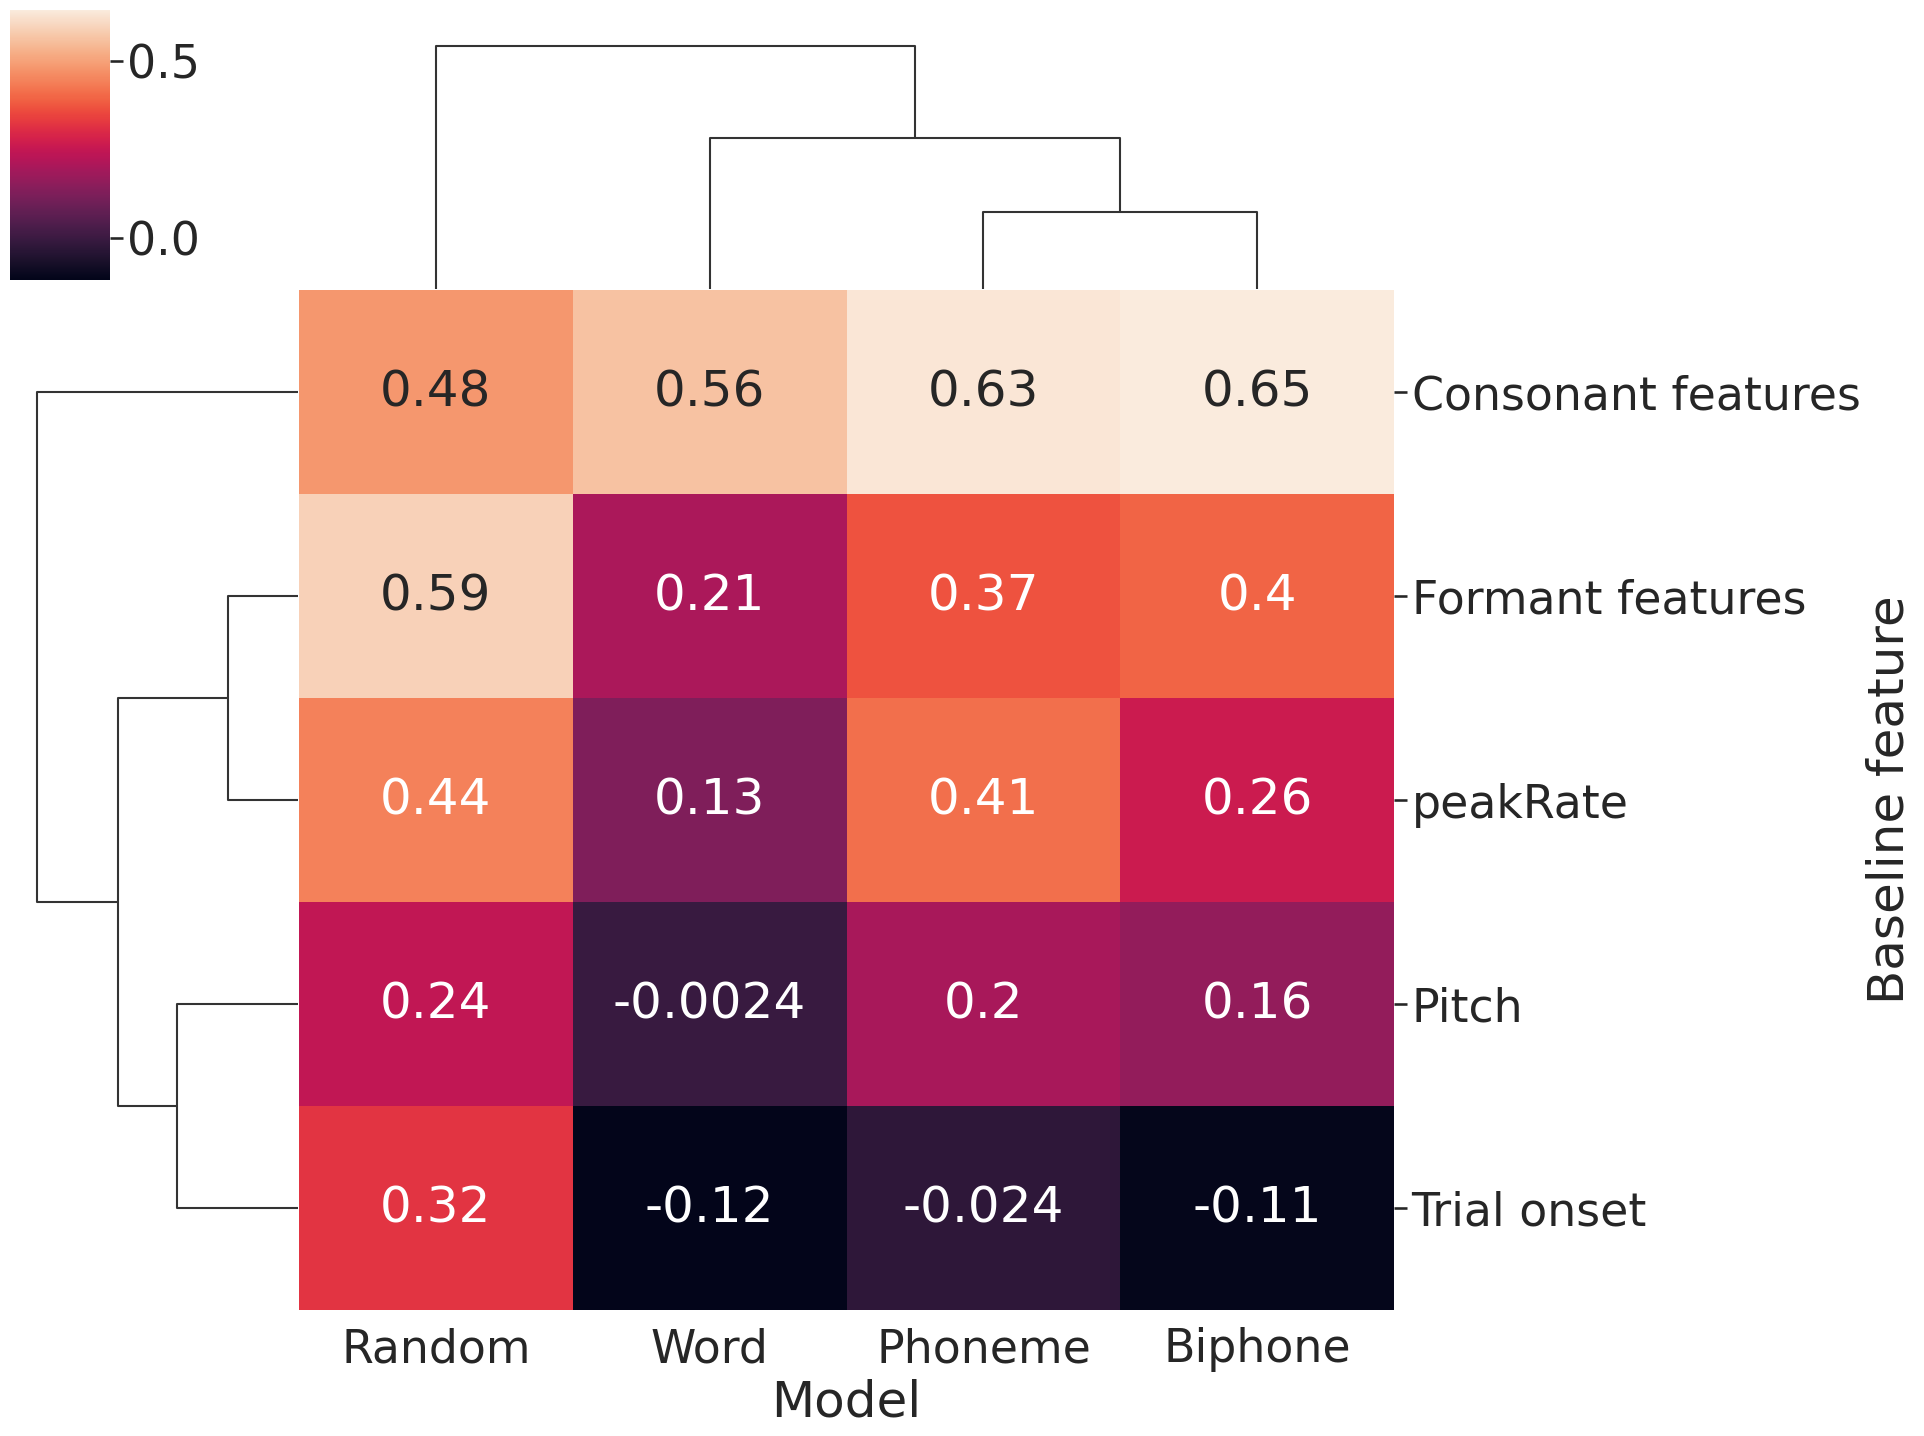

In [399]:
# Only with speech-responsive electrodes
improvement_correlations = pd.concat([model_embedding_improvements.loc[speech_responsive_electrodes],
                                      baseline_feature_improvements.loc[speech_responsive_electrodes]], axis=1) \
                 .corr("spearman").loc[baseline_feature_improvements.columns, model_embedding_improvements.columns]
improvement_correlations.columns = improvement_correlations.columns.map(study_model_code_to_name)
improvement_correlations.index = improvement_correlations.index.map(interpretable_feature_names)
g = sns.clustermap(improvement_correlations[list(study_models.keys())], tree_kws=dict(linewidth=1.5),
               figsize=(20, 15), annot=True)
g.ax_heatmap.set_xlabel("Model")
g.ax_heatmap.set_ylabel("Baseline feature")

In [402]:
improvement_correlations.agg(["mean", "max"])

model2,Biphone,Phoneme,Random,Word
mean,0.271857,0.318770,0.417221,0.155449
max,0.645460,0.634876,0.592292,0.563946


In [258]:
all_improvements = pd.merge(baseline_feature_improvements, model_embedding_improvements,
                            left_index=True, right_index=True, how="left", validate="one_to_one")

In [259]:
all_improvements

F0  formantMedOnset    maxDtL     onset  \
subject output_dim                                                  
EC152   0           0.000702              NaN       NaN  0.000008   
        1                NaN         0.000245       NaN       NaN   
        2           0.002554              NaN       NaN       NaN   
        3                NaN              NaN       NaN  0.000046   
        4                NaN              NaN  0.000065       NaN   
...                      ...              ...       ...       ...   
EC260   251              NaN              NaN  0.000011       NaN   
        252         0.001315              NaN       NaN  0.000096   
        253         0.013847         0.000178  0.000032  0.000444   
        254         0.026141         0.000182  0.000012  0.000928   
        255         0.026798         0.000484  0.000033  0.001020   

                    phnfeatConsOnset  biphone_recon   phoneme   random8  \
subject output_dim                                                        
EC152   0                   0.000508            NaN       NaN       NaN   
        1                        NaN       0.000612  0.000164  0.000070   
        2                        NaN            NaN       NaN       NaN   
        3                   0.000317            NaN       NaN  0.000106   
        4                   0.000164            NaN       NaN  0.000073   
...                              ...            ...       ...       ...   
EC260   251                      NaN            NaN  0.000210       NaN   
        252                 0.000199            NaN       NaN       NaN   
        253                 0.001263            NaN       NaN  0.000209   
        254                 0.001257            NaN       NaN  0.000347   
        255                 0.001861            NaN       NaN  0.000348   

                    word_broad-aniso2-w2v2_8  
subject output_dim                            
EC152   0                                NaN  
        1                            0.00027  
        2                                NaN  
        3                                NaN  
        4                                NaN  
...                                      ...  
EC260   251                              NaN  
        252                              NaN  
        253                              NaN  
        254                              NaN  
        255                              NaN  

[1664 rows x 9 columns]

<Axes: xlabel='F0', ylabel='word_broad-aniso2-w2v2_8'>

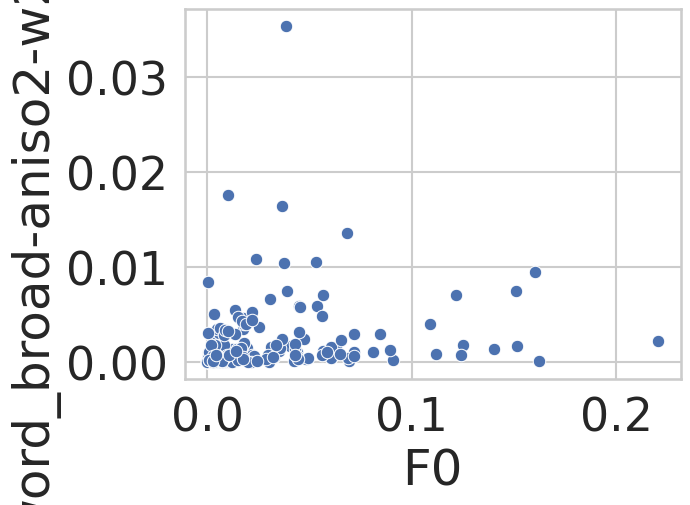

In [260]:
sns.scatterplot(data=all_improvements, x="F0", y="word_broad-aniso2-w2v2_8")

In [50]:
# represent improvement within each model as % of maximum unique variance
all_improvements_relative = all_improvements.apply(lambda xs: xs.div(xs.groupby("subject").agg(lambda ys: ys.max() - ys.min()).sub(xs.groupby("subject").min())), axis=0)
all_improvements_relative

F0  formantMedOnset    maxDtL     onset  \
subject output_dim                                                  
EC152   0           0.003180              NaN       NaN  0.008600   
        1                NaN         0.027451       NaN       NaN   
        2           0.011574              NaN       NaN       NaN   
        3                NaN              NaN       NaN  0.047336   
        4                NaN              NaN  0.049634       NaN   
...                      ...              ...       ...       ...   
EC260   251              NaN              NaN  0.021173       NaN   
        252         0.018302              NaN       NaN  0.042408   
        253         0.192708         0.044898  0.063529  0.196928   
        254         0.363800         0.045928  0.023405  0.411143   
        255         0.372945         0.122268  0.066325  0.451877   

                    phnfeatConsOnset  biphone_pred  biphone_recon  \
subject output_dim                                                  
EC152   0                   0.033561           NaN            NaN   
        1                        NaN           NaN       0.012418   
        2                        NaN           NaN            NaN   
        3                   0.020961           NaN            NaN   
        4                   0.010855           NaN            NaN   
...                              ...           ...            ...   
EC260   251                      NaN      0.004092            NaN   
        252                 0.002781           NaN            NaN   
        253                 0.017637           NaN            NaN   
        254                 0.017553           NaN            NaN   
        255                 0.025983           NaN            NaN   

                    next_phoneme   phoneme   random8  syllable  \
subject output_dim                                               
EC152   0                    NaN       NaN       NaN       NaN   
        1                    NaN  0.016609  0.032064       NaN   
        2               0.011792       NaN       NaN       NaN   
        3                    NaN       NaN  0.048632       NaN   
        4                    NaN       NaN  0.033644       NaN   
...                          ...       ...       ...       ...   
EC260   251                  NaN  0.006161       NaN       NaN   
        252                  NaN       NaN       NaN       NaN   
        253             0.011968       NaN  0.126914       NaN   
        254                  NaN       NaN  0.211267       NaN   
        255             0.021858       NaN  0.211773       NaN   

                    word_broad-aniso2-w2v2_8  
subject output_dim                            
EC152   0                                NaN  
        1                           0.025573  
        2                                NaN  
        3                                NaN  
        4                                NaN  
...                                      ...  
EC260   251                              NaN  
        252                              NaN  
        253                              NaN  
        254                              NaN  
        255                              NaN  

[1664 rows x 12 columns]

In [51]:
all_improvements_relative.sort_values("word_broad-aniso2-w2v2_8", ascending=False)

F0  formantMedOnset    maxDtL     onset  \
subject output_dim                                                  
EC183   151              NaN         0.391300  0.018297  0.046420   
EC196   119         0.495085         0.471999  0.549020  0.224655   
EC212   201         0.560715         0.028004  0.115699  0.199034   
EC195   122         0.149553              NaN  0.132927  0.994558   
EC260   206         0.533463         0.985840  0.999242  0.323869   
...                      ...              ...       ...       ...   
        251              NaN              NaN  0.021173       NaN   
        252         0.018302              NaN       NaN  0.042408   
        253         0.192708         0.044898  0.063529  0.196928   
        254         0.363800         0.045928  0.023405  0.411143   
        255         0.372945         0.122268  0.066325  0.451877   

                    phnfeatConsOnset  biphone_pred  biphone_recon  \
subject output_dim                                                  
EC183   151                 0.282339      0.304929       0.650438   
EC196   119                 0.757239      1.018974       1.004505   
EC212   201                 1.001006      1.000515       1.000225   
EC195   122                 0.192002      0.345321       0.556925   
EC260   206                 1.000509      1.000356       1.000091   
...                              ...           ...            ...   
        251                      NaN      0.004092            NaN   
        252                 0.002781           NaN            NaN   
        253                 0.017637           NaN            NaN   
        254                 0.017553           NaN            NaN   
        255                 0.025983           NaN            NaN   

                    next_phoneme   phoneme   random8  syllable  \
subject output_dim                                               
EC183   151             0.255768  0.342397  0.138354  1.002302   
EC196   119             0.123000  0.227251  0.884582  1.000509   
EC212   201             1.000046  1.000115  0.560135  1.000295   
EC195   122             0.344677  0.307130  0.307029  0.868894   
EC260   206             1.000115  1.000095  1.000055  1.000256   
...                          ...       ...       ...       ...   
        251                  NaN  0.006161       NaN       NaN   
        252                  NaN       NaN       NaN       NaN   
        253             0.011968       NaN  0.126914       NaN   
        254                  NaN       NaN  0.211267       NaN   
        255             0.021858       NaN  0.211773       NaN   

                    word_broad-aniso2-w2v2_8  
subject output_dim                            
EC183   151                         1.001445  
EC196   119                         1.001220  
EC212   201                         1.001097  
EC195   122                         1.000867  
EC260   206                         1.000782  
...                                      ...  
        251                              NaN  
        252                              NaN  
        253                              NaN  
        254                              NaN  
        255                              NaN  

[1664 rows x 12 columns]

### Colocation study by $p$-value

In [286]:
# get least-significant p-value result per model -- electrode
electrode_pvals = ttest_df.loc[(slice(None), slice(None), "baseline"), "log_pval"].groupby(["model2", "subject", "output_dim"]).max()
# insert zero pvals for missing model--electrode combinations
electrode_pvals = electrode_pvals.reindex(pd.MultiIndex.from_tuples([(model, subject, output_dim)
                                                                     for subject, output_dim in electrode_df.index
                                                                     for model in study_model_codes], names=["model2", "subject", "output_dim"])) \
    .fillna(0.)
electrode_pvals

model2                    subject  output_dim
random8                   EC195    0            -0.589253
phoneme                   EC195    0             0.000000
biphone_recon             EC195    0             0.000000
word_broad-aniso2-w2v2_8  EC195    0             0.000000
random8                   EC195    1            -2.861665
                                                   ...   
word_broad-aniso2-w2v2_8  EC152    326           0.000000
random8                   EC152    327           0.000000
phoneme                   EC152    327           0.000000
biphone_recon             EC152    327           0.000000
word_broad-aniso2-w2v2_8  EC152    327           0.000000
Name: log_pval, Length: 8064, dtype: float64

In [340]:
contrasts = {
    "word_dominant": (["word_broad-aniso2-w2v2_8"], ["phoneme", "biphone_pred", "biphone_recon", "random8"]),
    # "biphone_dominant": (["biphone_pred", "biphone_recon"], ["word_broad-aniso2-w2v2_8", "phoneme"]),
    "biphone_pred_dominant": (["biphone_pred"], ["biphone_recon", "word_broad-aniso2-w2v2_8", "phoneme", "random8"]),
    "biphone_recon_dominant": (["biphone_recon"], ["biphone_pred", "word_broad-aniso2-w2v2_8", "phoneme", "random8"]),
    "phone_dominant": (["biphone_pred", "biphone_recon", "phoneme"], ["word_broad-aniso2-w2v2_8", "random8"]),
    "random_dominant": (["random8"], ["phoneme", "biphone_pred", "biphone_recon", "word_broad-aniso2-w2v2_8"]),
}

In [341]:
electrode_pvals

model2                    subject  output_dim
random8                   EC195    0            -0.589253
phoneme                   EC195    0             0.000000
biphone_recon             EC195    0             0.000000
word_broad-aniso2-w2v2_8  EC195    0             0.000000
random8                   EC195    1            -2.861665
                                                   ...   
word_broad-aniso2-w2v2_8  EC152    326           0.000000
random8                   EC152    327           0.000000
phoneme                   EC152    327           0.000000
biphone_recon             EC152    327           0.000000
word_broad-aniso2-w2v2_8  EC152    327           0.000000
Name: log_pval, Length: 8064, dtype: float64

In [342]:
contrast_outcomes = {}
for contrast_name, (positive_models, negative_models) in tqdm(contrasts.items()):
    positive_models_ = set(positive_models) & set(study_model_codes)
    negative_models_ = set(negative_models) & set(study_model_codes)
    if not positive_models or not negative_models_:
        raise ValueError("Missing all negative models or all positive models")
    if positive_models_ != set(positive_models):
        L.warning("Missing some positive models: %s", set(positive_models) - positive_models_)
    if negative_models_ != set(negative_models):
        L.warning("Missing some negative models: %s", set(negative_models) - negative_models_)
    positive_models_ = list(positive_models_)
    negative_models_ = list(negative_models_)

    contrast_outcomes_i = electrode_pvals.groupby(["subject", "output_dim"]).apply(
        lambda xs: xs.loc[positive_models_].min() - xs.loc[negative_models_].min()) \
        .sort_values(ascending=True) \
        .rename("contrast_value").to_frame()
    contrast_outcomes_i["positive_pval"] = electrode_pvals.loc[positive_models_].groupby(["subject", "output_dim"]).min()
    contrast_outcomes[contrast_name] = contrast_outcomes_i
contrast_outcomes = pd.concat(contrast_outcomes, names=["contrast"])
contrast_outcomes

  0%|          | 0/5 [00:00<?, ?it/s]

Missing some negative models: {'biphone_pred'}
Missing some positive models: {'biphone_pred'}
Missing some negative models: {'biphone_pred'}
Missing some positive models: {'biphone_pred'}
Missing some negative models: {'biphone_pred'}


contrast_value  positive_pval
contrast        subject output_dim                               
word_dominant   EC183   9                -3.871348      -4.087660
                EC152   154              -3.849313      -3.849313
                EC196   184              -3.651403      -4.289097
                EC212   220              -3.498179      -5.474724
                EC196   8                -3.275592      -3.275592
...                                            ...            ...
random_dominant EC195   122               7.140807      -1.812441
                EC152   118               7.153633      -0.521599
                EC212   216               7.161569      -0.418928
                        201               8.792464      -1.706697
                        202               8.819956      -0.952657

[10080 rows x 2 columns]

In [343]:
spotlight_results = {}
for contrast, outcomes_i in contrast_outcomes.groupby("contrast"):
    outcomes_i["outcome"] = None
    outcomes_i.loc[(outcomes_i.positive_pval <= -2) & (outcomes_i.contrast_value <= -1), "outcome"] = "positive"
    outcomes_i.loc[(outcomes_i.positive_pval <= -2) & (outcomes_i.contrast_value >= 1), "outcome"] = "negative"
    outcomes_i.loc[(outcomes_i.positive_pval <= -2) & (outcomes_i.contrast_value.abs() <= 0.5), "outcome"] = "balanced"
    spotlight_results[contrast] = outcomes_i
spotlight_results = pd.concat(spotlight_results.values())

In [344]:
# pivot outcome to columns
spotlight_results_pivot = spotlight_results.reset_index().pivot(index=["subject", "output_dim"], columns="contrast", values=["outcome", "contrast_value"])
spotlight_results_pivot = spotlight_results_pivot[~spotlight_results_pivot.outcome.isna().all(axis=1)]
spotlight_results_pivot

outcome                         \
contrast           biphone_pred_dominant biphone_recon_dominant   
subject output_dim                                                
EC152   1                           None                   None   
        10                          None               balanced   
        13                          None                   None   
        16                          None                   None   
        17                          None               balanced   
...                                  ...                    ...   
EC260   239                         None               negative   
        242                         None                   None   
        247                         None               positive   
        251                         None                   None   
        253                         None                   None   

                                                                 \
contrast           phone_dominant random_dominant word_dominant   
subject output_dim                                                
EC152   1                    None        positive          None   
        10               positive            None          None   
        13               positive            None          None   
        16               positive            None          None   
        17               positive            None          None   
...                           ...             ...           ...   
EC260   239              positive        negative          None   
        242                  None        positive          None   
        247              positive            None      negative   
        251              positive            None          None   
        253                  None        positive          None   

                          contrast_value                         \
contrast           biphone_pred_dominant biphone_recon_dominant   
subject output_dim                                                
EC152   1                            NaN               1.698395   
        10                           NaN               0.069366   
        13                           NaN                6.09908   
        16                           NaN              -0.954379   
        17                           NaN               0.037649   
...                                  ...                    ...   
EC260   239                          NaN               1.302628   
        242                          NaN               3.405586   
        247                          NaN              -3.028759   
        251                          NaN               2.209923   
        253                          NaN               5.153282   

                                                                 
contrast           phone_dominant random_dominant word_dominant  
subject output_dim                                               
EC152   1                1.698395       -1.698395      2.601274  
        10              -2.537978        2.537978       2.70186  
        13               -6.09908         6.09908       6.09908  
        16              -1.946968        1.946968      2.402959  
        17              -2.652751        2.652751      2.652751  
...                           ...             ...           ...  
EC260   239              -1.16043         1.16043      3.893091  
        242              3.405586       -3.405586      3.405586  
        247             -3.028759        4.920776      3.028759  
        251             -2.209923        2.209923      2.209923  
        253              5.153282       -5.153282      5.153282  

[506 rows x 10 columns]

/tmp/ipykernel_2746198/353906758.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")


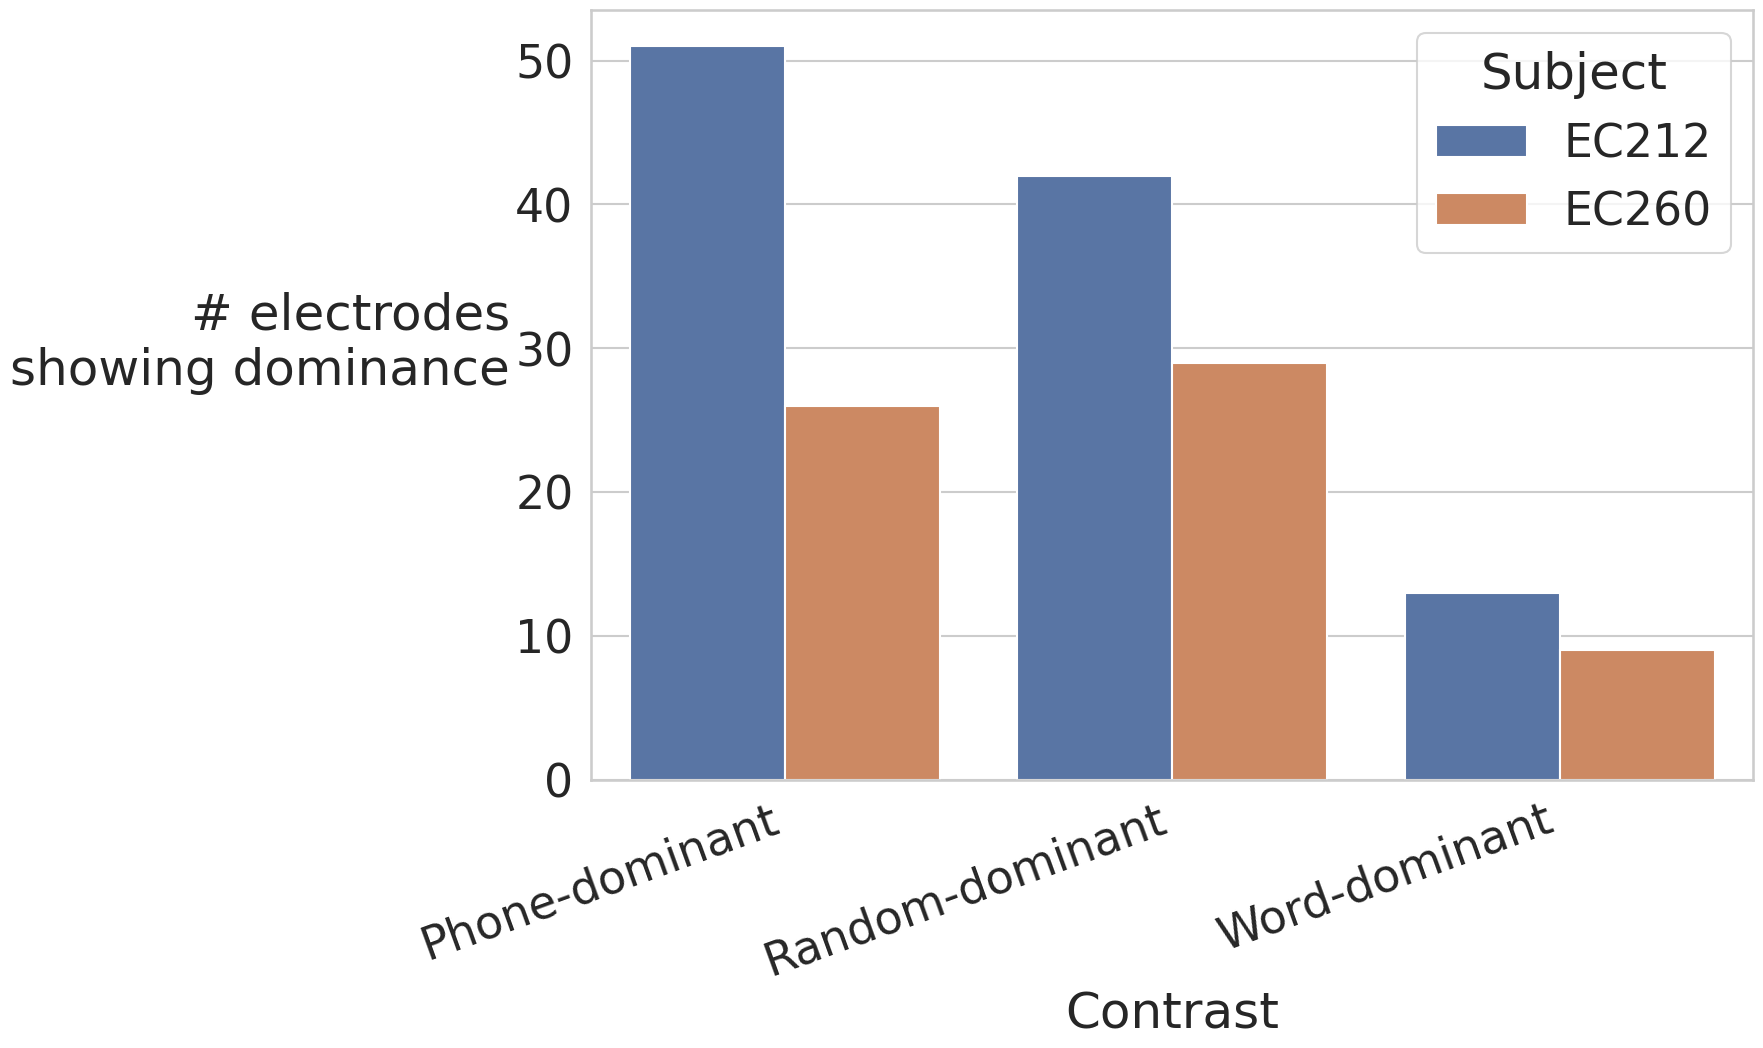

In [348]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=spotlight_results[spotlight_results.outcome == "positive"]
                    .loc[["random_dominant", "word_dominant", "phone_dominant"]].loc[(slice(None), plot_subjects), :]
                    .groupby(["contrast", "subject"]).size().rename("# electrodes showing dominance").reset_index()
                    .assign(Contrast=lambda xs: xs.contrast.map(lambda name: name.capitalize().replace("_", "-"))),
            x="Contrast", y="# electrodes showing dominance", hue="subject", ax=ax)
ax.set_ylabel("# electrodes\nshowing dominance", ha="right", ma="right", rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
ax.get_legend().set_title("Subject")

Text(0, 0.5, '$\\log_{10}$ $p$-value\nof model comparison')

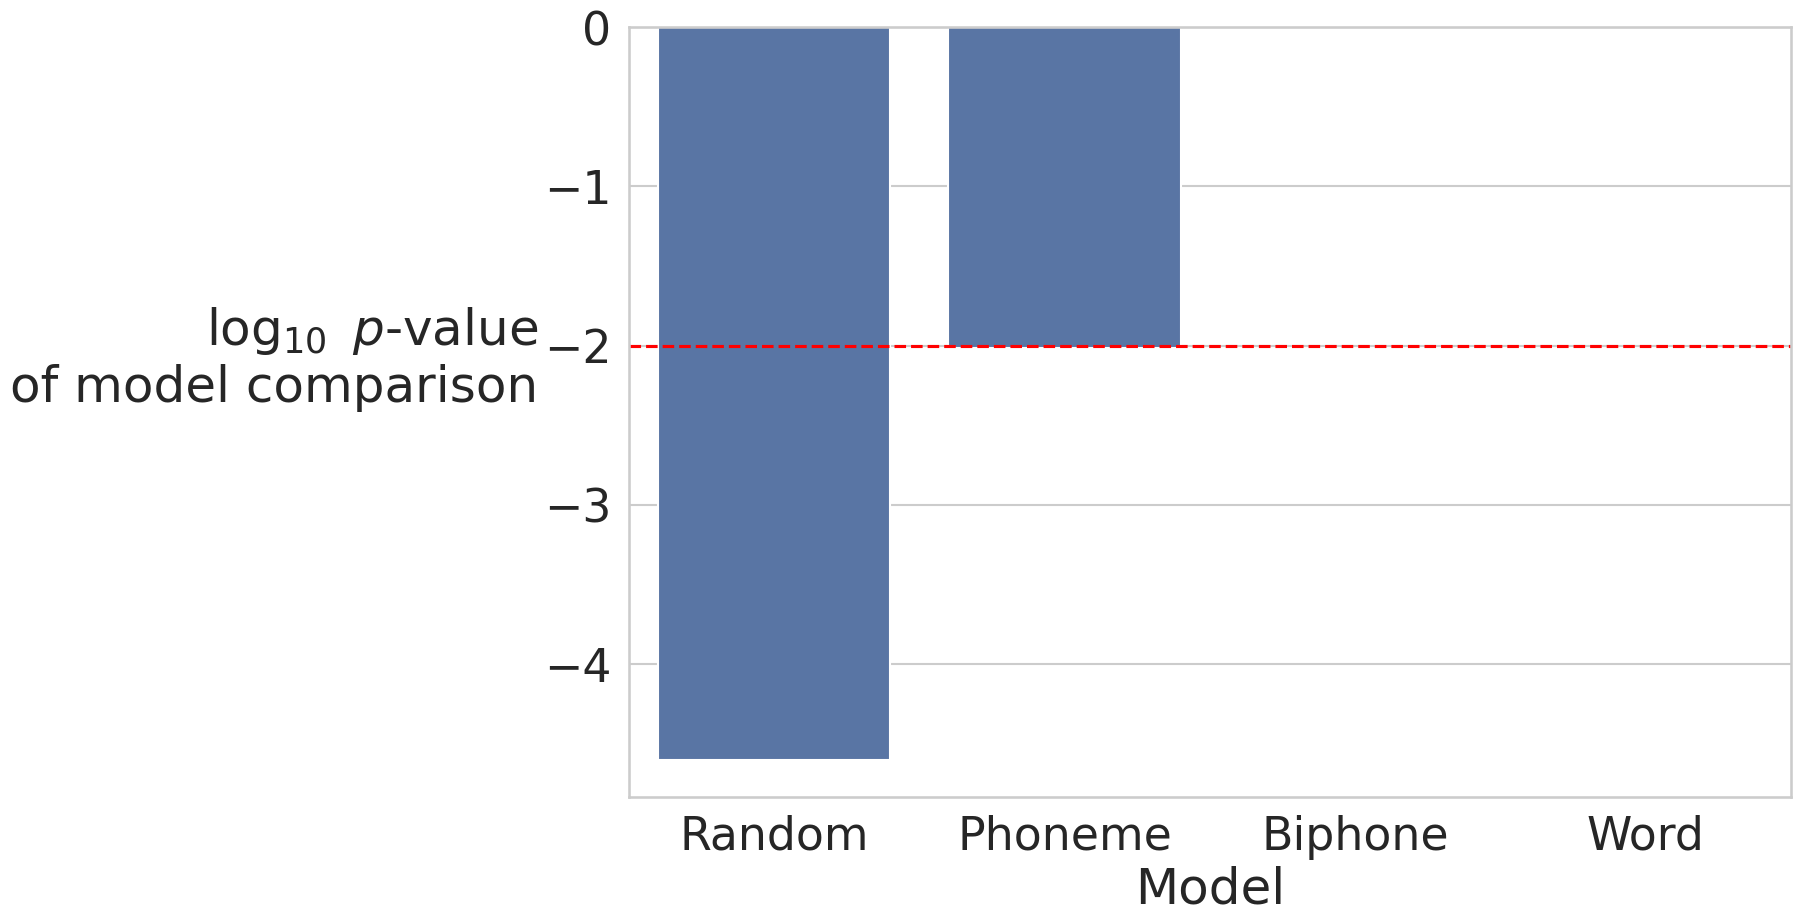

In [320]:
dominance_demo = electrode_pvals.loc[(slice(None), "EC212", 234)].reset_index()
dominance_demo["model_name"] = dominance_demo.model2.map(study_model_code_to_name)
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=dominance_demo, x="model_name", y="log_pval", ax=ax)
ax.axhline(np.log10(1e-2), color="red", linestyle="--")
ax.set_xlabel("Model")
ax.set_ylabel("$\log_{10}$ $p$-value\nof model comparison", ha="right", ma="right", rotation=0)

In [350]:
contrast_outcomes.loc["phone_dominant"].loc["EC212"]

,contrast_value,positive_pval
output_dim,,
202,-5.613090,-9.772613
39,-4.498821,-4.498821
217,-4.494289,-4.557631
216,-4.490730,-7.580497
218,-4.271544,-5.485131
...,...,...
107,3.886731,0.000000
220,4.170811,-1.303913
102,4.371559,0.000000


Text(0, 0.5, '$\\log_{10}$ $p$-value\nof model comparison')

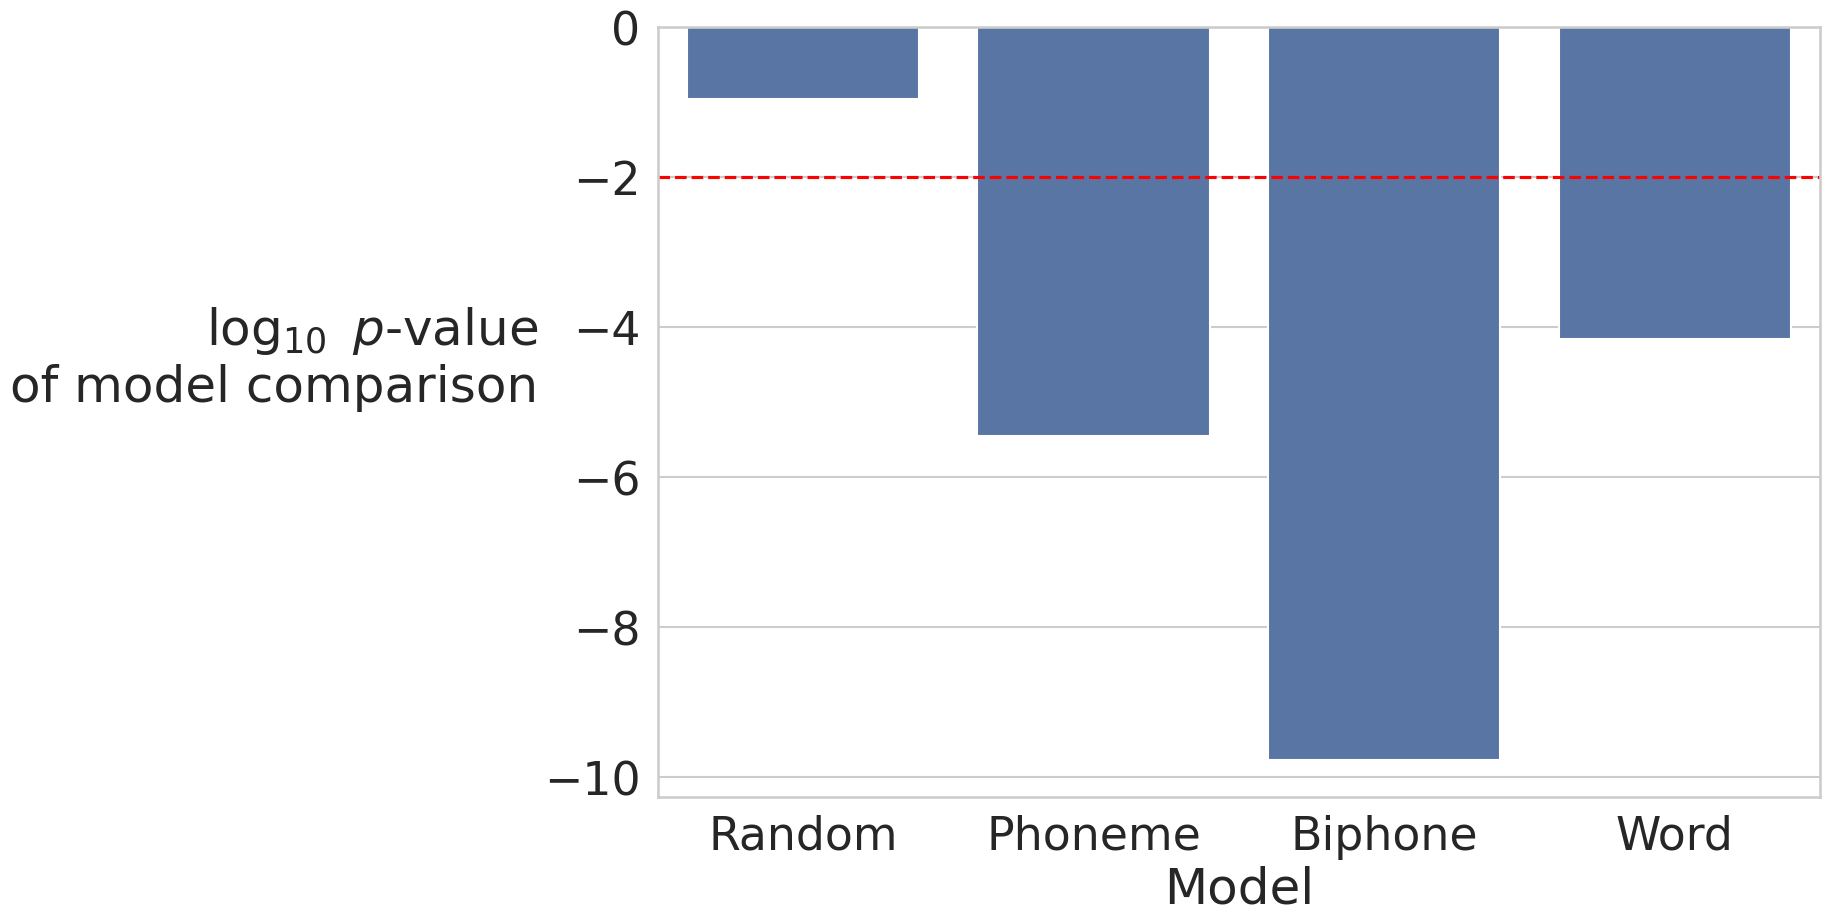

In [351]:
dominance_demo = electrode_pvals.loc[(slice(None), "EC212", 202)].reset_index()
dominance_demo["model_name"] = dominance_demo.model2.map(study_model_code_to_name)
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=dominance_demo, x="model_name", y="log_pval", ax=ax)
ax.axhline(np.log10(1e-2), color="red", linestyle="--")
ax.set_xlabel("Model")
ax.set_ylabel("$\log_{10}$ $p$-value\nof model comparison", ha="right", ma="right", rotation=0)

In [163]:
spotlight_results.to_csv("spotlight_result.csv")